# Overview
This Notebook is used to reproduce all Figures in the paper "Validating Small-Molecule Force Fields for Macrocyclic Compounds Using NMR Data in Different Solvents"

# Naming conventions
* in the code, the force fields have simplified names: OpenFF 2 -> openff; GaFF 2 -> amber; OPLS/AA -> opls; XFF/DASH -> xff-dash
* The compounds are called by the first author of the paper, plus the compound name. You can find all names in the COMPOUNDS_PRETTY dict

## The Simulation class
This notebook uses the `Simulation` class to specify a simulation to be loaded.
The Simulation class knows about folder structure, filenames etc. In this Notebook, it is only used to find a csv file, but it also works
with many of the post-processing functions.

**Usage:** `Simulation("compound", "forcefield", "simulation_method", "solvent")`

### Available settings
* compound: `begnini-compound-1`, `begnini-compound-2`, `poongavanam-g16`, `poongavanam-e2-enant`, `danelius-rifampicin`, `danelius-roxithromycin`, `danelius-telithromycin`, `danelius-spiramycin`, `danelius-rifampicin-charged`, `danelius-roxithromycin-charged`, `danelius-telithromycin-charged`, `danelius-spiramycin-charged`, `peng-lorlatinib`, `comeau-nleu5r`, `comeau-nleu5s`
* forcefield: `openff` (OpenFF 2.0), `amber` (GaFF 2), `opls` (OPLS/AA), `xff-dash` (XFF with DASH charges)
* method: `hremd-quadratic` (REST2 with quadratic lambda placement), `hremd-exponential` (REST2 with exponential lambda placement, only for a few compounds)
* solvent: `chcl3`, `water` (only for a few compounds), `dmso` (only for a few compounds)

# Setup

In [1]:
from copy import deepcopy
from io import BytesIO, StringIO
import json
from tempfile import TemporaryDirectory
import threading
from time import sleep
from ast import literal_eval
import os.path
import random

import rdkit.Chem.AllChem
from rdkit import Chem

from PIL import Image
import IPython.display
import mdtraj as md
import numpy as np
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial.transform

from file_structure import Simulation, molfile_path
from post_processing_functions import trajectory, center_traj

Chem.rdDepictor.SetPreferCoordGen(True)

In [2]:
COMPOUNDS_PRETTY = {
    'begnini-compound-1': 'BC1',
    'begnini-compound-2': 'BC2',
    'poongavanam-g16': 'G16',
    'poongavanam-e2-enant': 'E2-enant',
    'danelius-rifampicin': 'Rifampicin',
    'danelius-roxithromycin': 'Roxithromycin',
    'danelius-telithromycin': 'Telithromycin',
    'danelius-spiramycin': 'Spiramycin',
    'danelius-rifampicin-charged': 'Rifampicin',
    'danelius-rifampicin-zwitterion': 'Rifampicin',
    'danelius-roxithromycin-charged': 'Roxithromycin',
    'danelius-telithromycin-charged': 'Telithromycin',
    'danelius-spiramycin-charged': 'Spiramycin',
    'peng-lorlatinib': 'Lorlatinib',
    'comeau-nleu5r': 'NLeu5R',
    'comeau-nleu5s': 'NLeu5S',
    'roche-1': 'RO1',
    'roche-2': 'RO2',
    'roche-3': 'RO3',
    'roche-4': 'RO4',
    'roche-5': 'RO5',
    'roche-6': 'RO6',
}

FORCEFIELDS_PRETTY = {
    "openff": "OpenFF 2",
    "openff-confs": "OpenFF 2 (10)",
    "amber": "GAFF2",
    "opls": "OPLS/AA",
    "xff-dash": "XFF/DASH",
}

In [3]:
_sim = Simulation("poongavanam-e2-enant", "openff", "hremd-quadratic", "water")

In [4]:
_mol = Chem.MolFromMolFile(molfile_path(_sim.compound), removeHs=False)
Chem.GetShortestPath(_mol, 1, 20)

(1, 2, 24, 23, 22, 21, 20)

In [5]:
def distance_ring_classification(sim, idx_1, idx_2):
    """Classify the distance idx_1 - idx_2 into internal, external, or mixed with respect to the macrocycle.
    
    Assumes that idx_1 and idx_2 are hydrogen atoms, so the distance is classified
    as internal even if those two atoms are outside the ring, as long as all atoms
    inbetween are in the ring.
    """
    mol = Chem.MolFromPDBFile(sim.pdb_filename(), removeHs=False)
    path = set(Chem.GetShortestPath(mol, idx_1, idx_2)[1:-1])
    macrocycle = set(max(Chem.GetSSSR(mol), key=len))
    if path.intersection(macrocycle) == path:  # full overlap
        return "macrocycle"
    elif path.intersection(macrocycle): # partial overlap
        return "mixed"
    else:
        return "extracyclic"
    

def get_results_table(sim):
    df = pd.read_csv(
        f"outputs/match-to-noes/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}.csv",
        index_col=0,
    ).set_index("restraint_number")
    df['violation'] = df['computed_distance'] - df['distance_ab']
    df['ring_classification'] = [
        distance_ring_classification(sim, literal_eval(row['index_a'])[0], literal_eval(row['index_b'])[0])
        for _, row in df.iterrows()
    ]
    return df

get_results_table(Simulation("poongavanam-e2-enant", "opls", "hremd-quadratic", "chcl3"))

proton_a proton_b  delta_a  delta_b     sigma    r2  \
restraint_number                                                       
1                      24       23     7.49     2.87  0.000003  0.99   
2                     16'       21     4.70     1.26  0.000022  0.99   
3                      7'       19     2.01     3.32  0.000014  0.99   
4                     10'       20     1.52     2.94  0.000014  0.99   
5                       6       7'     3.51     2.01  0.000031  0.94   
6                      7'      8''     2.01     1.23  0.000055  0.99   
7                     7''      8''     1.70     1.23  0.000031  0.97   
8                    10''      11'     2.17     3.16  0.000024  0.96   
9                     10'      11'     1.52     3.16  0.000017  0.96   

                  distance_ab index_a       index_b  top_distance  \
restraint_number                                                    
1                        3.90    [65]  [57, 58, 59]           6.0   
2                        2.71    [56]  [51, 52, 53]           5.0   
3                        2.90    [38]  [34, 35, 36]           5.0   
4                        2.92    [44]  [48, 49, 47]           5.0   
5                        2.55    [37]          [38]           3.0   
6                        2.32    [38]          [41]           3.0   
7                        2.55    [39]          [41]           3.0   
8                        2.67    [43]          [46]           3.0   
9                        2.81    [44]          [46]           3.0   

                  computed_distance  distance_split_0  distance_split_1  \
restraint_number                                                          
1                          3.777913          3.778318          3.800972   
2                          5.000461          4.947072          5.031113   
3                          3.451718          3.362426          3.374214   
4                          3.538427          3.464911          3.481408   
5                          2.927306          2.887896          2.897051   
6                          2.936061          2.892135          2.904365   
7                          2.447248          2.445516          2.447804   
8                          2.306310          2.308188          2.313096   
9                          2.948327          2.923698          2.938261   

                  distance_split_2  distance_split_3  distance_split_4  \
restraint_number                                                         
1                         3.771731          3.771720          3.767483   
2                         4.982794          5.031019          5.013999   
3                         3.498737          3.535963          3.515211   
4                         3.573138          3.603268          3.585686   
5                         2.945656          2.956093          2.955149   
6                         2.955480          2.966513          2.968150   
7                         2.448520          2.445524          2.448892   
8                         2.307796          2.304190          2.298461   
9                         2.965845          2.967117          2.948345   

                 ring_classification  violation  
restraint_number                                 
1                              mixed  -0.122087  
2                              mixed   2.290461  
3                        extracyclic   0.551718  
4                              mixed   0.618427  
5                        extracyclic   0.377306  
6                        extracyclic   0.616061  
7                        extracyclic  -0.102752  
8                         macrocycle  -0.363690  
9                         macrocycle   0.138327

## Aggregation functions

In [6]:
def root_mean_square(arr):
    " sqrt(mean(x**2)) "
    return np.sqrt(np.mean(arr**2))

def mean_positive(arr):
    " mean(max(x, 0)) "
    return np.mean(np.maximum(arr, 0))

def mean_absolute(arr):
    " mean(abs(x)) "
    return np.mean(np.abs(arr))

def fraction_above(arr, cutoff=1):
    " fraction of values above a cutoff "
    return np.mean(arr > cutoff)

## Helper functions

In [7]:
def sort_by_nth_lowest(df, n):
    nth_lowest = np.sort(df.values, axis=1)[:, n]
    return df.iloc[np.argsort(nth_lowest)]

def standard_md_method(compound):
    return "hremd-with-angles" if compound == "peng-lorlatinib" else "hremd-quadratic"

In [8]:
# These functions are for visualization of MDTraj objects using NGLView

class MDTrajTrajectory2(nv.MDTrajTrajectory):
    def __init__(self, trajectory, rdk_mol=None):
        self.rdk_mol = rdk_mol
        super().__init__(trajectory)

    def get_structure_string(self):
        if self.rdk_mol is None:
            super().get_structure_string()
        return Chem.MolToPDBBlock(self.rdk_mol)

def show_mdtraj2(mdtraj_trajectory, rdk_mol=None, **kwargs):
    '''Show mdtraj trajectory with optional Rdkit mol for bond info.

    Examples
    --------
    >>> import nglview as nv # doctest: +SKIP
    ... import mdtraj as md
    ... t = md.load(nv.datafiles.XTC, top=nv.datafiles.GRO)
    ... w = nv.show_mdtraj2(t)
    ... w
    '''
    structure_trajectory = MDTrajTrajectory2(mdtraj_trajectory, rdk_mol=rdk_mol)
    return nv.NGLWidget(structure_trajectory, **kwargs)


def add_bounds_to_view(view, traj, atoms1, atoms2):
    new_traj = get_dummy_mdtraj_2_atoms()
    new_traj.xyz = np.zeros((traj.n_frames, new_traj.n_atoms, 3))
    new_traj.xyz[:, 0, :] = traj.xyz[:, atoms1, :].mean(1)
    new_traj.xyz[:, 1, :] = traj.xyz[:, atoms2, :].mean(1)
    view.add_trajectory(new_traj)


def get_render_results(view, results):
    """Collect the results of rendering frames in NGLview
    
    Note: Rendering has to be done in a separate thread to unblock the main thread.
    
    Parameters
    ----------
    view: NGLWidget
    results: list
        To store the output (each element will be a bytes object with the png image)
    """
    for i_frame in range(N_CLUSTERS):
        img = view.render_image(frame=i_frame, transparent=True)
        maxsteps = 50
        for _ in range(maxsteps):
            if img.value:
                break
            sleep(0.1)
        results.append(deepcopy(img.value))


def get_dummy_mdtraj_2_atoms():
    """This will serve as a template to add 2-atom representations (for distance bounds) to an NGLview widget"""
    with TemporaryDirectory() as tmp:
        fname = f"{tmp}/temp.pdb"
        with open(fname, "w") as f:
            print(
"""ATOM      1  Cl1 MOL     1      00.000  00.000  00.000  1.00  0.00           Cl 
ATOM      2  Cl2 MOL     1      00.000  00.000  00.000  1.00  0.00           Cl 
CONECT    1    2
""", file=f)
        traj = md.load_pdb(fname)
    return traj

def get_ring_orientation(mol: Chem.Mol, xyz=None, atoms_offset=0, invert_ring=False):
    """Return the *current* rotation matrix corresponding to the longest ring in mol.
    
    Rotation is such that the first atom points roughly in -x direction, and the atoms at 1/4 of the ring point roughly in y direction.
    """
    assert atoms_offset >= 0
    ring = list(max(Chem.GetSSSR(mol), key=len))
    ring = ring[atoms_offset:] + ring[:atoms_offset]
    if invert_ring:
        ring = ring[::-1]
    if xyz is None:
        crd = np.array(mol.GetConformer().GetPositions())
    else:
        crd = xyz
    ring_crd = crd[ring]
    # center of geometry
    center = np.mean(ring_crd, axis=0)
    ring_crd -= center
    t = np.linspace(0, 2*np.pi, len(ring), endpoint=False)[:, np.newaxis]
    x = (-np.cos(t) * ring_crd).sum(0)
    x = x / np.sqrt(np.sum(x**2))
    y = (np.sin(t) * ring_crd).sum(0)
    # force y to be normal to x
    proj = (x*y).sum() * x
    y -= proj
    y = y / np.sqrt(np.sum(y**2))
    z = np.cross(x, y)
    z = z / np.sqrt(np.sum(z**2))
    # x, y, z are columns of the rotation matrix
    rotmat = np.stack([x, y, z], axis=-1)
    return rotmat, center

def transform_into_standard_orientation(xyz, ref_mol, atoms_offset, invert_ring=False):
    rotmat, center = get_ring_orientation(ref_mol, xyz=xyz, atoms_offset=atoms_offset, invert_ring=invert_ring)
    xyz = np.asarray(xyz) - center
    xyz = np.matmul(np.linalg.inv(rotmat), xyz.T).T
    return xyz

In [9]:
mol = Chem.MolFromMolFile("../data/danelius-roxithromycin-charged/reference-atom-order.mol")
#assert get_ring_orientation(mol, 0) == [1, 54, 41, 40, 27, 24, 23, 21, 12, 11, 9, 6, 3, 2]
rotmat, center = get_ring_orientation(mol, atoms_offset=3)
(rotmat[:, 0] * rotmat[:, 1]).sum()

-6.938893903907228e-18

# Figure 1: Compounds

In [10]:
def show_images(imgs, buffer=5, n_per_row=4):
    height = max(img.height for img in imgs)
    width = max(img.width for img in imgs)
    total_width = width*n_per_row + buffer * (n_per_row-1)
    n_rows = (len(imgs)-1) // n_per_row + 1
    total_height = height*n_rows + buffer * (n_rows-1)
    res = Image.new("RGBA", (total_width, total_height), color="#fff")
    for i, img in enumerate(imgs):
        ix = i % n_per_row
        iy = i // n_per_row
        res.paste(img, (ix*(width+buffer), iy*(height+buffer)))
    return res

def show_mol(mol, legend='', extra_highlight=None):
    sssr = [list(ring) for ring in Chem.GetSSSR(mol)]
    longest_ring = max(sssr, key=len)

    width, height = 350, 300
    d2d = Chem.Draw.MolDraw2DCairo(width, height)
    d2d.SetFontSize(18)
    dopts = d2d.drawOptions()
    highlight_color = {i: (0.6, 1, 1, 1) for i in longest_ring}
    if extra_highlight is not None:
        for match in mol.GetSubstructMatches(extra_highlight):
            highlight_color[match[0]] = (1.0, 0.6, 0.4, 1)
    d2d.DrawMolecule(mol, legend=legend, highlightAtoms=list(highlight_color), highlightAtomColors=highlight_color)
    d2d.FinishDrawing()
    bio = BytesIO(d2d.GetDrawingText())
    return Image.open(bio)

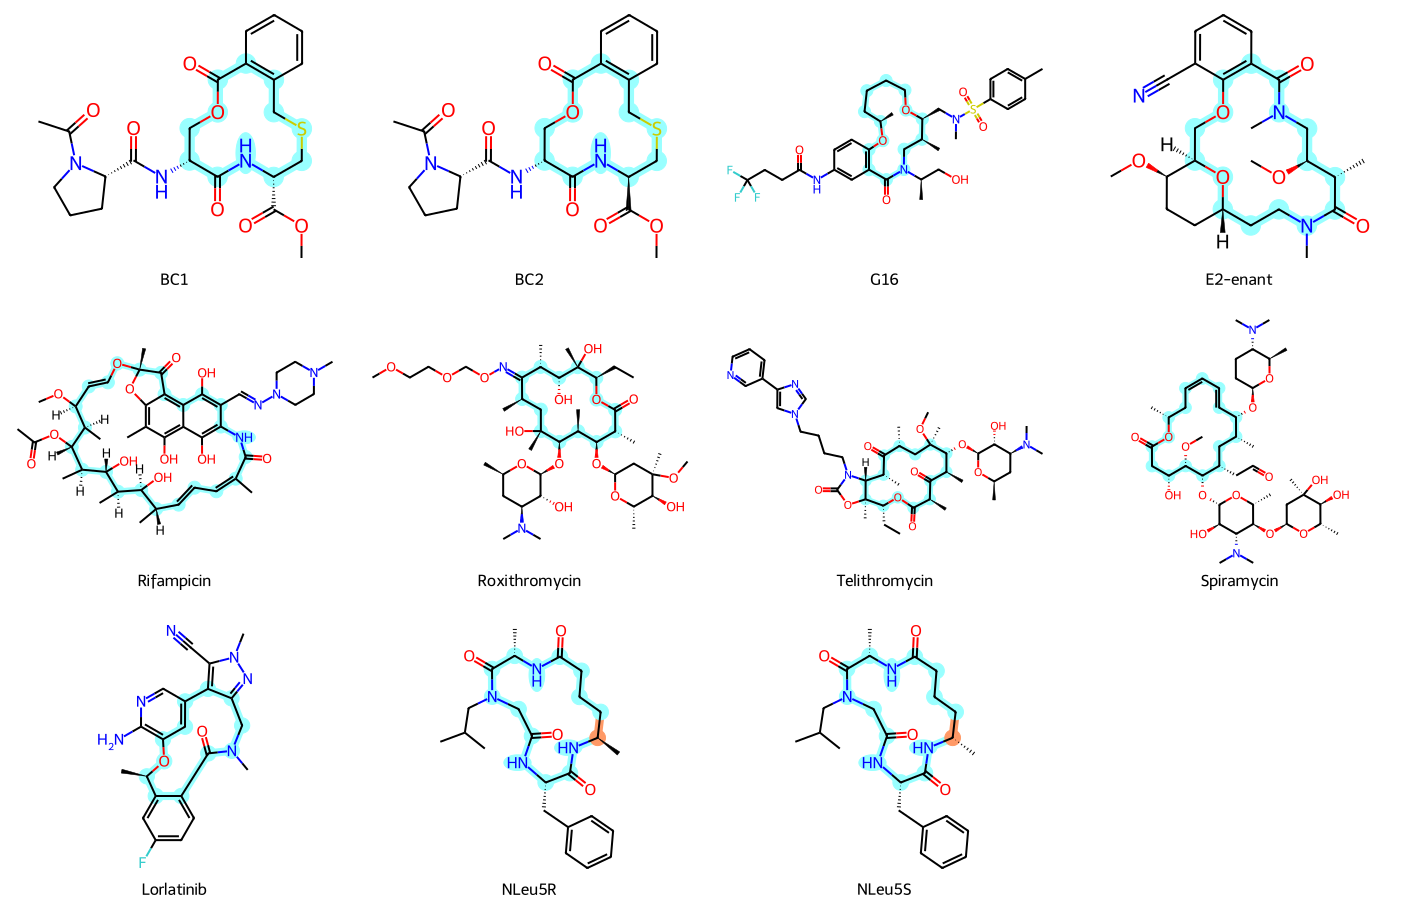

In [11]:
compounds = [c for c in COMPOUNDS_PRETTY if not c.startswith("roche")]
nleu_chiral_c_query = Chem.MolFromSmarts(r"[C:1](C)(NC=O)(CCCC=O)")
mols = {
    c: Chem.Mol(Chem.MolFromMolFile(molfile_path(c)), quickCopy=True)
    for c in compounds
}

imgs = []
for name, mol in mols.items():
    if "charged" not in name and "zwitterion" not in name:
        if name in ("comeau-nleu5s", "comeau-nleu5r"):
            imgs.append(show_mol(mol, legend=COMPOUNDS_PRETTY[name], extra_highlight=nleu_chiral_c_query))
        else:
            imgs.append(show_mol(mol, legend=COMPOUNDS_PRETTY[name]))

img = show_images(imgs, n_per_row=4)
with open("outputs/figure-mols.png", "wb") as f:
    img.save(f, format="png")
img

# Plots for individual simulations

In [12]:
ANGSTROM_PER_NM = 10.

def norm_and_cmap_for_topological_distance(cmap='viridis'):
    cmap = plt.get_cmap(cmap, 9)
    norm = plt.cm.colors.Normalize(2 - 0.5, 10 + 0.5)
    return norm, cmap

def colorcode_topological_distances(distances):
    norm, cmap = norm_and_cmap_for_topological_distance()
    colors = cmap(norm(distances))
    return colors

def create_colorbar_for_topological_distance(figure=None, **kwargs):
    figure = figure or plt.gcf()
    norm, cmap = norm_and_cmap_for_topological_distance()
    c_title = "Topological distance"
    cbar = figure.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), **kwargs)
    cbar.set_label(c_title)
    return cbar

def make_plot(simulation, ax=None, title=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Remove NOE distances between hydrogens on the same carbon
    #colors = colorcode_topological_distances(plot_df['top_distance'].values)
    #cbar = create_colorbar_for_topological_distance(ax=ax)
    # Plot
    ax.bar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, label='full') # , color=colors
    N_CHUNKS = 5
    # Plot chunks as individual points
    #for i in range(N_CHUNKS):
    #    violation = (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']) / ANGSTROM_PER_NM
    #    ax.scatter(violation.index, violation, label=f"split {i+1}", s=10)
    # Plot chunks as min-max bars
    chunk_violations = [
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']) / ANGSTROM_PER_NM
        for i in range(N_CHUNKS)
    ]
    chunk_min = -(np.min(chunk_violations, axis=0) - plot_df['violation'] / ANGSTROM_PER_NM)
    chunk_max = np.max(chunk_violations, axis=0) - plot_df['violation'] / ANGSTROM_PER_NM
    plt.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, [chunk_min, chunk_max], linestyle="", color='k', capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    title = f'NOE violations (Compound={simulation.compound})' if title is None else title
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]', title=title)
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

## Figure 2: BC1, NLeu5S

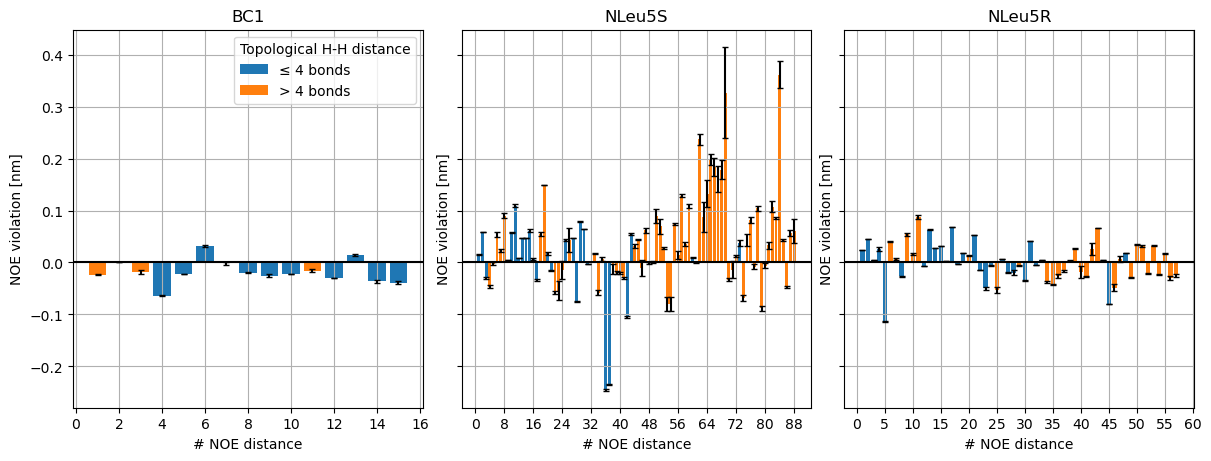

In [13]:
def make_plot(simulation, frame_selection=None, ax=None, use_ring_distance=False, restraints_df=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.query('top_distance <= 4.0').index, plot_df.query('top_distance <= 4.0')['violation'] / ANGSTROM_PER_NM, label='≤ 4 bonds')
    ax.bar(plot_df.query('top_distance > 4.0').index, plot_df.query('top_distance > 4.0')['violation'] / ANGSTROM_PER_NM, label='> 4 bonds')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]')
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), sharey=True, layout='constrained')

sims = {
    #"Lorlatinib": Simulation("peng-lorlatinib", "openff", "hremd-with-angles", "chcl3"),
    "BC1": Simulation("begnini-compound-1", "openff", "hremd-quadratic", "chcl3"),
    "NLeu5S": Simulation("comeau-nleu5s", "openff", "hremd-quadratic", "chcl3"),
    "NLeu5R": Simulation("comeau-nleu5r", "openff", "hremd-quadratic", "chcl3"),
}

for ax, (title, sim) in zip(axes, sims.items()):
    make_plot(sim, ax=ax)
    ax.set_title(title)
    ax.grid()
axes[0].legend(title="Topological H-H distance", alignment="left")
plt.savefig("outputs/figure-2-bc1-nleu5s-example.png", dpi=300)
plt.show()

# Aggregated plots

## Figure 4: Chloroform, Water & DMSO

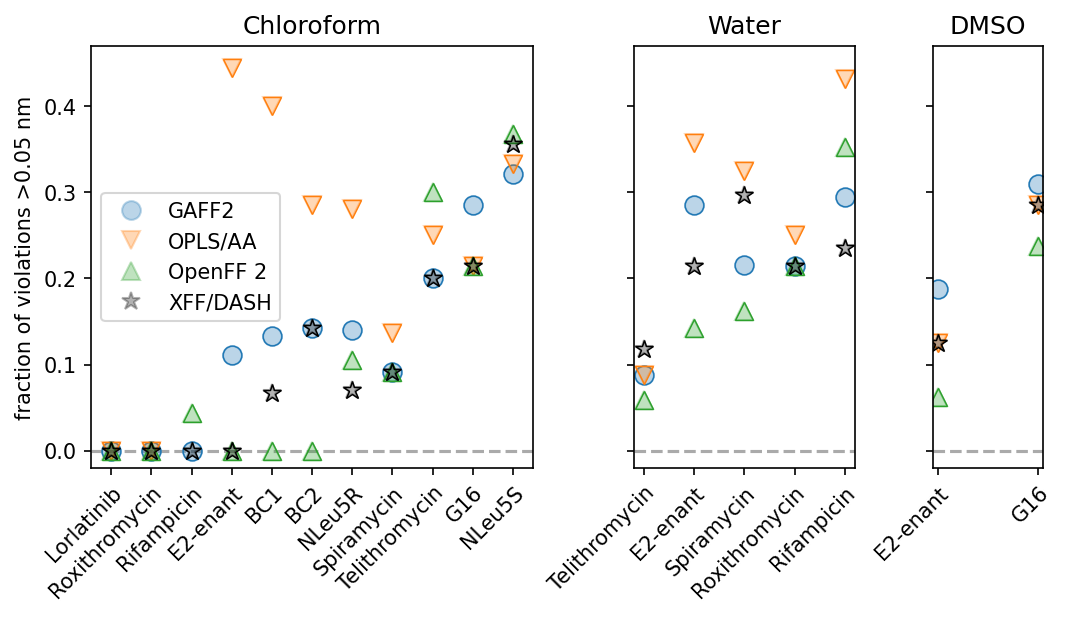

In [14]:
# Setup
fig, axes = plt.subplots(1, 3, figsize=(7, 4), dpi=150, layout='constrained', sharey=True, gridspec_kw={'width_ratios': [4, 2, 1]})
aggregation = lambda x: fraction_above(x, cutoff=.5)

colors = [row['color'] for row in plt.rcParams['axes.prop_cycle']][:5]
colors[3] = '#000'

#forcefields = list(FORCEFIELDS_PRETTY.keys())
forcefields = ['openff', 'amber', 'opls', 'xff-dash']

SOLVENT_COMPOUNDS = [
    ("chcl3", "Chloroform", [
        'begnini-compound-1', 'begnini-compound-2',
        'poongavanam-g16', 'poongavanam-e2-enant',
        'danelius-rifampicin', 'danelius-roxithromycin', 'danelius-telithromycin', 'danelius-spiramycin',
        'peng-lorlatinib',
        'comeau-nleu5r', 'comeau-nleu5s',
    ]),
    ("water", "Water", [
        'poongavanam-e2-enant',
        'danelius-rifampicin-zwitterion', 'danelius-roxithromycin-charged', 'danelius-telithromycin-charged', 'danelius-spiramycin-charged',
    ]),
    ("dmso", "DMSO", ['poongavanam-e2-enant', 'poongavanam-g16']),
]

for ax, (solvent, solvent_pretty, compounds) in zip(axes, SOLVENT_COMPOUNDS):
    ax.axhline(0, color='#aaa', linestyle='--')
    plot_df = pd.Series({
        (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
            Simulation(compound, ff, standard_md_method(compound), solvent),
        )['violation']
        for compound in compounds
        for ff in forcefields
        if (compound, ff) != ('danelius-rifampicin', 'opls')
    })
    plot_df_agg = plot_df.map(aggregation).unstack(level=1)
    # sort by the lowest value
    for n in range(3, -1, -1):
        plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)
    for col, marker, color in zip(plot_df_agg, "ov^*<", colors):
        ax.plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
        ax.plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
    plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylim(-0.02, 0.47)
    ax.set_title(solvent_pretty)

axes[0].set_ylim(-0.02, 0.47)
axes[0].set(ylabel="fraction of violations >0.05 nm")
axes[0].legend()
plt.savefig("outputs/figure-4-frac-violations-over-0.5.png", dpi=300)
plt.show()

## Overall performance metric
* Computes the average rate of violations over all compounds
* Performs bootstraping by selecting random samples of the simulations. The bootstrap error quantifies the different performance between compounds. Note: the significance-test for the different force fields is in the next section.

In [15]:
plot_data = []
bootstrap_index = []
for ax, (solvent, solvent_pretty, compounds) in zip(axes, SOLVENT_COMPOUNDS):
    for compound in compounds:
        bootstrap_index.append((solvent, COMPOUNDS_PRETTY[compound]))
        for ff in forcefields:
            if (compound, ff) != ('danelius-rifampicin', 'opls'):
                sim = Simulation(compound, ff, standard_md_method(compound), solvent)
                table = get_results_table(sim).assign(solvent=solvent, compound=COMPOUNDS_PRETTY[compound], forcefield=FORCEFIELDS_PRETTY[ff])
                plot_data.append(table) 
plot_data = pd.concat(plot_data).reset_index().set_index(["solvent", "compound", "forcefield", "restraint_number"])
viol = plot_data["violation"] > 0.5
mean_viol = viol.groupby("forcefield").mean().to_frame()
print(mean_viol.to_string(float_format="%.3f"))

            violation
forcefield           
GAFF2           0.202
OPLS/AA         0.271
OpenFF 2        0.188
XFF/DASH        0.190


In [16]:
N_BOOTSTRAP = 10
random.seed(1)
viol_ex = viol.groupby(level=["solvent", "compound", "forcefield", "restraint_number"]).first()
for i in range(N_BOOTSTRAP):
    bs_sample = [random.choice(bootstrap_index) for _ in bootstrap_index]
    bs_viol = pd.concat([viol.loc[row] for row in bs_sample])
    mean_viol[i] = bs_viol.groupby("forcefield").mean()
mean_viol["std"] = mean_viol[list(range(N_BOOTSTRAP))].std(axis=1)
mean_viol[["violation", "std"]].multiply(100).style.format("{:.1f}")

/tmp/ipykernel_2211651/3262908653.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  bs_viol = pd.concat([viol.loc[row] for row in bs_sample])
/tmp/ipykernel_2211651/3262908653.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  bs_viol = pd.concat([viol.loc[row] for row in bs_sample])
/tmp/ipykernel_2211651/3262908653.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  bs_viol = pd.concat([viol.loc[row] for row in bs_sample])
/tmp/ipykernel_2211651/3262908653.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  bs_viol = pd.concat([viol.loc[row] for row in bs_sample])
/tmp/ipykernel_2211651/3262908653.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  bs_viol = pd.concat([viol.loc[row] for row in bs_sample])
/tmp/ipykernel_2211651/3262908653.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  bs_viol = pd.concat([viol.

In [17]:
viol_fractions = viol.groupby(level=["solvent", "compound", "forcefield"]).mean().unstack(level="forcefield")
viol_fractions

forcefield                GAFF2   OPLS/AA  OpenFF 2  XFF/DASH
solvent compound                                             
chcl3   BC1            0.133333  0.400000  0.000000  0.066667
        BC2            0.142857  0.285714  0.000000  0.142857
        E2-enant       0.111111  0.444444  0.000000  0.000000
        G16            0.285714  0.214286  0.214286  0.214286
        Lorlatinib     0.000000  0.000000  0.000000  0.000000
        NLeu5R         0.140351  0.280702  0.105263  0.070175
        NLeu5S         0.321839  0.333333  0.367816  0.356322
        Rifampicin     0.000000       NaN  0.043478  0.000000
        Roxithromycin  0.000000  0.000000  0.000000  0.000000
        Spiramycin     0.090909  0.136364  0.090909  0.090909
        Telithromycin  0.200000  0.250000  0.300000  0.200000
dmso    E2-enant       0.187500  0.125000  0.062500  0.125000
        G16            0.309524  0.285714  0.238095  0.285714
water   E2-enant       0.285714  0.357143  0.142857  0.214286
        Rifampicin     0.294118  0.431373  0.352941  0.235294
        Roxithromycin  0.214286  0.250000  0.214286  0.214286
        Spiramycin     0.216216  0.324324  0.162162  0.297297
        Telithromycin  0.088235  0.088235  0.058824  0.117647

## Statistical significance tests

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scikit_posthocs

In [19]:
friedman_df = viol_fractions.dropna()

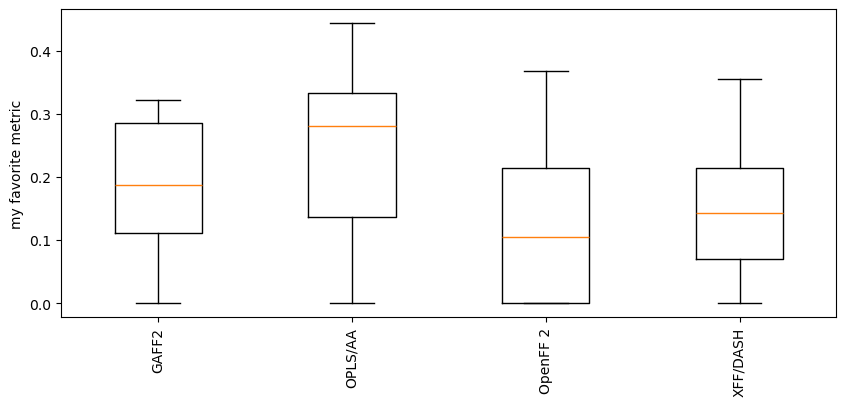

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
data = list(friedman_df.values.T)
labels = list(friedman_df.columns)
ax.boxplot(data, labels=labels)
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("my favorite metric")
plt.show()

In [21]:
scipy.stats.friedmanchisquare(*data)

FriedmanchisquareResult(statistic=13.545454545454524, pvalue=0.003593934067960375)

In [22]:
pw_wilcox = scikit_posthocs.posthoc_wilcoxon(data)
n_cols = len(pw_wilcox.columns)
different = [(labels[i], labels[j]) for i in range(n_cols-1) for j in range(i+1, n_cols) if pw_wilcox.iloc[i, j] < 0.05]
print("The following pairs are different:")
print(*different, sep='\n')

The following pairs are different:
('GAFF2', 'OPLS/AA')
('GAFF2', 'OpenFF 2')
('OPLS/AA', 'OpenFF 2')
('OPLS/AA', 'XFF/DASH')


In [23]:
wilcox_greater_lesser = []
for a, b in different:
    result = scipy.stats.wilcoxon(friedman_df[a], friedman_df[b], alternative="greater")._asdict()
    result.update(dict(a=a, b=b, test="a > b"))
    wilcox_greater_lesser.append(result)
for a, b in different:
    result = scipy.stats.wilcoxon(friedman_df[a], friedman_df[b], alternative="less")._asdict()
    result.update(dict(a=a, b=b, test="a < b"))
    wilcox_greater_lesser.append(result)
wilcox_greater_lesser = pd.DataFrame(wilcox_greater_lesser)
wilcox_greater_lesser.query('pvalue < 0.05')

statistic    pvalue        a         b   test
1       75.0  0.019592    GAFF2  OpenFF 2  a > b
2       97.0  0.002607  OPLS/AA  OpenFF 2  a > b
3       74.0  0.003020  OPLS/AA  XFF/DASH  a > b
4       15.0  0.009283    GAFF2   OPLS/AA  a < b

## Comparison OpenFF with standard / averaged charges

/fileserver/pine/pine5/fwaibl/macrocycle-ff-validation/code/outputs/figure-off-confs-frac-violations-over-0.5.png


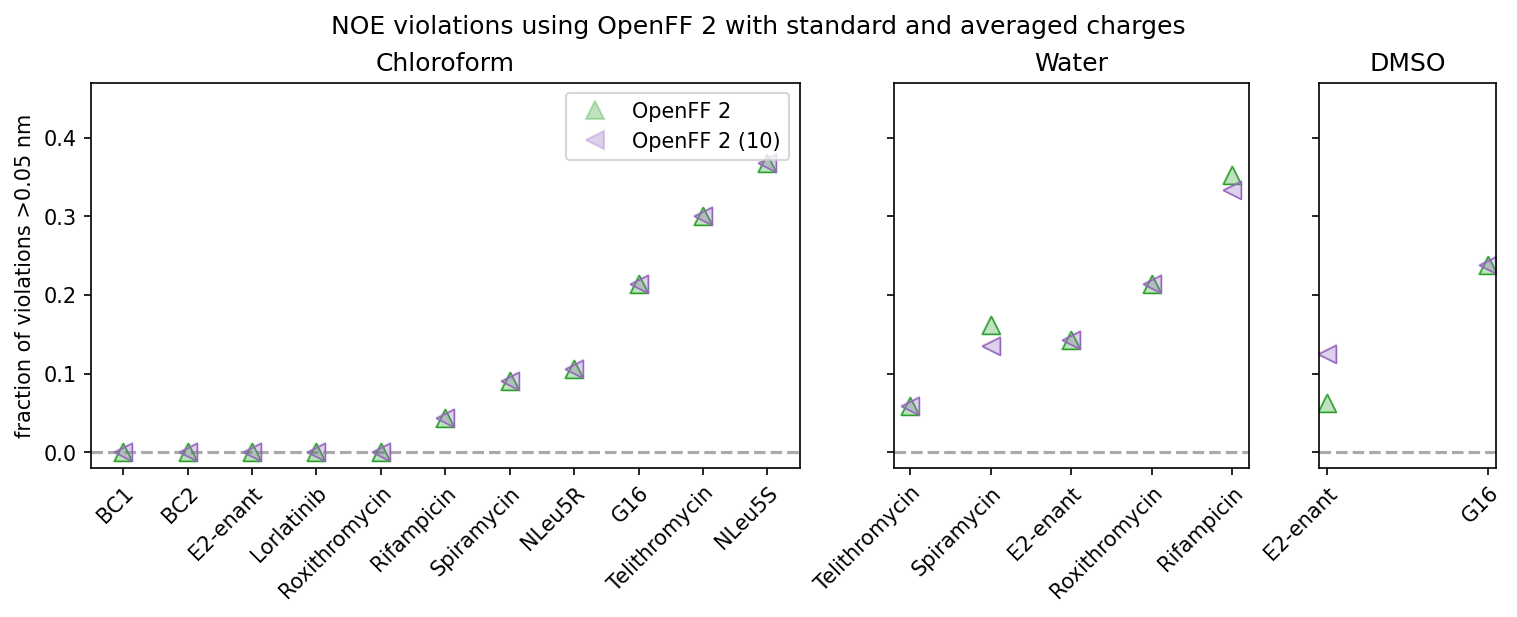

In [24]:
# Setup
fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=150, layout='constrained', sharey=True, gridspec_kw={'width_ratios': [4, 2, 1]})
aggregation = lambda x: fraction_above(x, cutoff=.5)

all_colors = [row['color'] for row in plt.rcParams['axes.prop_cycle']]
colors = [all_colors[i] for i in [2, 4]]

#forcefields = list(FORCEFIELDS_PRETTY.keys())
forcefields = ['openff', 'openff-confs']

SOLVENT_COMPOUNDS = [
    ("chcl3", "Chloroform", [
        'begnini-compound-1', 'begnini-compound-2',
        'poongavanam-g16', 'poongavanam-e2-enant',
        'danelius-rifampicin', 'danelius-roxithromycin', 'danelius-telithromycin', 'danelius-spiramycin',
        'peng-lorlatinib',
        'comeau-nleu5r', 'comeau-nleu5s',
    ]),
    ("water", "Water", [
        'poongavanam-e2-enant',
        'danelius-rifampicin-zwitterion', 'danelius-roxithromycin-charged', 'danelius-telithromycin-charged', 'danelius-spiramycin-charged',
    ]),
    ("dmso", "DMSO", ['poongavanam-e2-enant', 'poongavanam-g16']),
]

for ax, (solvent, solvent_pretty, compounds) in zip(axes, SOLVENT_COMPOUNDS):
    ax.axhline(0, color='#aaa', linestyle='--')
    plot_df = pd.Series({
        (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
            Simulation(compound, ff, standard_md_method(compound), solvent),
        )['violation']
        for compound in compounds
        for ff in forcefields
        if (compound, ff) != ('danelius-rifampicin', 'opls')
    })
    plot_df_agg = plot_df.map(aggregation).unstack(level=1)
    # sort by the lowest value
    for n in range(1, -1, -1):
        plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)
    for col, marker, color in zip (plot_df_agg, "^<", colors):
        ax.plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
        ax.plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
    plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_ylim(-0.02, 0.47)
    ax.set_title(solvent_pretty)

axes[0].set_ylim(-0.02, 0.47)
axes[0].set(ylabel="fraction of violations >0.05 nm")
axes[0].legend()
fig.suptitle("NOE violations using OpenFF 2 with standard and averaged charges")
fname = "outputs/figure-off-confs-frac-violations-over-0.5.png"
plt.savefig(fname, dpi=300)
print(os.path.join(os.getcwd(), fname))
plt.show()

## Figure 6: Roche compounds figure
**It will not be possible to run this without the (unpublished) simulations of the Roche compounds**

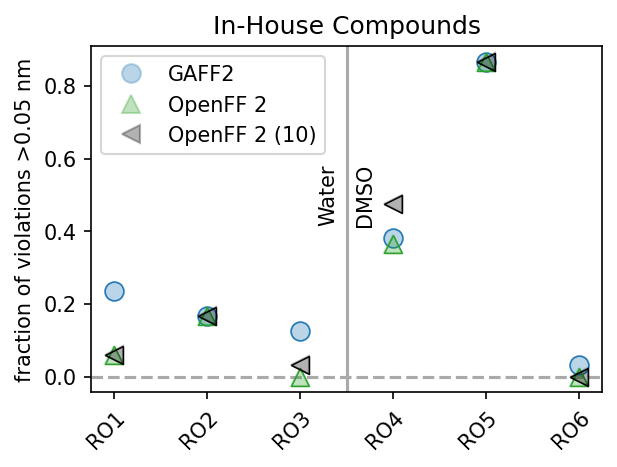

In [25]:
compounds_and_solvents = [("water", ['roche-1', 'roche-2', 'roche-3']), ("dmso", ['roche-4', 'roche-5', 'roche-6'])]
forcefields = ["openff", "openff-confs", "amber"]

def standard_md_method(compound):
    return "hremd-with-angles" if compound == "peng-lorlatinib" else "hremd-quadratic"

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150, layout='constrained')
aggregation = lambda x: fraction_above(x, cutoff=.5)
plot_df = pd.Series({
    (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
        Simulation(compound, ff, standard_md_method(compound), solvent),
    )['violation']
    for solvent, compounds in compounds_and_solvents
    for compound in compounds
    for ff in forcefields
})

ax.axhline(0, color='#aaa', linestyle='--')

colors = [row['color'] for row in plt.rcParams['axes.prop_cycle']][:4]
colors[3] = '#000'
# select colors to be consistent with the colors for GAFF2 and OpenFF 2 in Figure 4
colors = [colors[0], colors[2], colors[3]]

plot_df_agg = plot_df.map(aggregation).unstack(level=1)
#for n in range(1, -1, -1):
#    plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)

# also use the appropriate markers to be consistent with Figure 4
for col, marker, color in zip (plot_df_agg, "o^<", colors):
    ax.plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
    ax.plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')

ax.axvline(2.5, color="#aaa")
ax.text(2.3, 0.5, "Water", rotation=90, ha="center", va="center")
ax.text(2.7, 0.5, "DMSO", rotation=90, ha="center", va="center")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_title("In-House Compounds")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set(ylabel="fraction of violations >0.05 nm")
ax.legend()
plt.savefig("outputs/figure-6-frac-violations-over-0.5-roche.png", dpi=300)
plt.show()

# Figure 3: NLeu5S clusters
## Important notes
* This figure requires that `nleu5s-clustering.sh` has been run, and its output files are there.

**Workflow:**
* Adapt the `ATOMS_OFFSET` to rotate along the ring. And possibly use `INVERT_RING` to flip the whole molecule by 180 degrees (the molecule is set into a standard orientation based on the ring. `INVERT_RING` reverts the order of the atoms when creating the reference orientation.)
* Zoom in and/or move the molecule to fit the figure as tightly as possible, but don't rotate.
* Move the frames slider at least once to make sure that all parts of the view are at the same frame.
* Run the cell that renders the 5 frames. Then *wait* until it is done.
* *After the rendering is done*, run the cell that saves the png files.
* Run the cell that displays the final figure as HTML.
* Then, screenshot the figure. If you want the exact size, you can take a screenshot from the developer console.

## Function definitions

In [26]:
cm = nv.color.ColormakerRegistry

cm.add_scheme_func(
    "ring_color",
    """
    this.atomColor = function(atom) {
        if (atom.element == "H") {return "0xFFFFFF";}
        if (atom.element == "C") {return "0x606060";}
        if (atom.element == "N") {return "0x3050F8";}
        if (atom.element == "O") {return "0xFF0D0D";}
        if (atom.element == "F") {return "0x90E050";}
    };
    """
)
cm.add_scheme_func(
    "out_of_ring_color",
    """
    this.atomColor = function(atom) {
        if (atom.element == "H") {return "0xFFFFFF";}
        if (atom.element == "C") {return "0xaaaaaa";}
        if (atom.element == "N") {return "0x3050F8";}
        if (atom.element == "O") {return "0xFF0D0D";}
        if (atom.element == "F") {return "0x90E050";}
    };
    """
)

def rgb2hex(r, g, b, _a=None):
    print(any([isinstance(x, float) for x in (r, g, b)]))
    if any([isinstance(x, float) for x in (r, g, b)]):
        r = min(int(r*256), 255)
        g = min(int(g*256), 255)
        b = min(int(b*256), 255)
    print(r, g,b )
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

## Load cluster populations and violations

In [27]:
#COMPOUND = "comeau-nleu5s"
COMPOUND = "danelius-spiramycin"
cluster_pops = pd.read_csv(f"outputs/clustering/{COMPOUND}-cluster-summary.dat", delim_whitespace=True, index_col="#Cluster")["Frac"]
cluster_pops

/tmp/ipykernel_2211651/1228774698.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cluster_pops = pd.read_csv(f"outputs/clustering/{COMPOUND}-cluster-summary.dat", delim_whitespace=True, index_col="#Cluster")["Frac"]


#Cluster
0    0.637
1    0.363
2    0.000
3    0.000
4    0.000
Name: Frac, dtype: float64

In [28]:
idx_viol = get_results_table(Simulation(COMPOUND, "openff", "hremd-quadratic", "chcl3"))[["violation", "index_a", "index_b"]].sort_values("violation", ascending=False)
idx_viol.head()

violation index_a   index_b
restraint_number                             
19                 0.754360    [67]     [117]
3                  0.576024    [67]      [76]
6                  0.303637    [65]      [76]
12                 0.260598    [66]  [77, 78]
1                  0.091051    [67]      [73]

## Render NGLview
**Note: the initial rendering looks wrong (bounds and structure are from different frames). Move the frame slider back and forth to get a correct rendering**

In [29]:
N_CLUSTERS = 5
bounds = idx_viol.sort_values("violation", ascending=False).head(5)#.query("violation > 0.5")
BOUND_COLOR = "#cccc00"  # dark yellow
bound_cmap = plt.get_cmap("inferno_r")

mol = Chem.MolFromMolFile(f"../data/{COMPOUND}/reference-atom-order.mol", removeHs=False)
ring = list(max(Chem.GetSSSR(mol), key=len))

visible_hs = set()
for _, row in bounds.iterrows():
    visible_hs.update(literal_eval(row["index_a"]))
    visible_hs.update(literal_eval(row["index_b"]))

traj = md.join([
    md.load(f"./outputs/clustering/{COMPOUND}-cluster.c{i}.pdb")
    #md.load(f"./outputs/clustering/comeau-nleu5s-cluster.c{i}.pdb")
    for i in range(0, N_CLUSTERS)
])

visible_hs.update([at.GetIdx() for at in mol.GetAtoms() if at.GetSymbol() == "H" and at.GetNeighbors()[0].GetSymbol() in ["N", "O"]])
H_SEL = ",".join([str(i) for i in visible_hs])
RING_SEL = ",".join([str(i) for i in ring])

rep = [
    # ring
    # sticks only - we want to set stick width independent of the ball
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 1.2,
        "cylinderOnly": True,
        "sele": f"@{RING_SEL}",
        "color": "ring_color",
    }},
    # everything else
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "out_of_ring_color",
        "sele": f"not _H or @{H_SEL}",  # polar hydrogens and those used in the bounds
    }},
    # ring
    # ball+stick
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "ring_color",
        "sele": f"@{RING_SEL}",
    }},
]

traj.center_coordinates()
traj = traj.superpose(traj, 0)
view = show_mdtraj2(traj, mol)
view.clear_representations()
view.representations = rep

i_view = 1
for _, row in bounds.iterrows():
    #color = rgb2hex(*bound_cmap(np.clip((row['violation'] - 0.5) / 0.5, 0, 1)))
    add_bounds_to_view(view, traj, literal_eval(row["index_a"]), literal_eval(row["index_b"]))
    view[i_view].clear()
    view[i_view].add_spacefill(colorValue=BOUND_COLOR, radiusScale=0.12)
    view[i_view].add_ball_and_stick(radiusScale=.6, colorValue=BOUND_COLOR, cylinderOnly=True)
    i_view += 1

view.display(gui=True)

ThemeManager()

NGLWidget(gui_style='ngl', max_frame=4)

In [45]:
results = []
thread = threading.Thread(target=get_render_results, args=(view, results))
thread.start()

## Save images

In [46]:
for i, img in enumerate(results):
    with open(f"outputs/clustering/{COMPOUND}-cluster.c{i}.png", "wb") as f:
        f.write(img)

## Display final figure

In [47]:
# using suffix 1 to distinguish styles from those in the other HTML cell below
cluster_title_html = "\n".join([
    f'<td class="mytable1">Cluster {i} ({cluster_pops[i]*100:.1f}%)</td>'
    for i in range(N_CLUSTERS)
])
#cluster_pop_html = "\n".join([f'<td class="mytable1">{cluster_pops[i]*100:.1f}%</td>' for i in range(N_CLUSTERS)])
cluster_img_html = "\n".join([f'<td class="mytable1"><img class="myimage1" src="outputs/clustering/{COMPOUND}-cluster.c{i}.png"></td>' for i in range(N_CLUSTERS)])
html_fig = """
<style>
    td.mytable1 {text-align: center !important; color: #000; background-color: #fff !important; font-size: 14pt; font-weight: bold; padding: 0pt}
    img.myimage1 {max-height: 100%;}
</style>
<table style="width: 1150pt; max-height: 200pt;">
<tr>""" + cluster_title_html + """</tr>
<tr>""" + cluster_img_html + """</tr>
</table>
"""
IPython.display.display(IPython.display.HTML(html_fig))

# Figure 5: Roxithromycin and Telithromycin
**workflow:**
* run this with all combinations of roxithromycin/telithromycin and `water`/`chcl3`. Note that the names are e.g., `danelius-roxithromycin` in chlroform, and `danelius-roxithromycin-charged` in water.
* For each combination:
  * Adapt the `ATOMS_OFFSET` to rotate along the ring. And possibly use `INVERT_RING` to flip the whole molecule by 180 degrees (the molecule is set into a standard orientation based on the ring. `INVERT_RING` reverts the order of the atoms when creating the reference orientation.)
  * Zoom in and/or move the molecule to fit the figure as tightly as possible, but don't rotate.
  * Move the frames slider at least once to make sure that all parts of the view are at the same frame.
  * Run the cell that renders the 5 frames. Then *wait* until it is done.
  * *After the rendering is done*, run the cell that saves the png files.
* In contrast to Figure 3, the panels of Figure 5 were assembled using the Scribus software rather than directly in the Notebook.

In [30]:
CMP = "danelius-roxithromycin"
SOLVENT = "chcl3"
ATOMS_OFFSET = 11  # rotates the orientation of the ring in the visualizations
INVERT_RING = True
# 11/True for roxithromycin/chcl3 or roxithromycin/water
# 13/False for telithromycin/water or telithromycin/chcl3

In [31]:
# get the strongest violations
idx_viol = get_results_table(Simulation(CMP, "openff", "hremd-quadratic", SOLVENT))[["violation", "index_a", "index_b"]].sort_values("violation", ascending=False)
idx_viol.head()

violation index_a          index_b
restraint_number                                    
19                 0.374236   [111]  [121, 122, 123]
11                 0.300797    [70]     [65, 66, 67]
10                 0.288690    [70]     [81, 82, 83]
18                 0.280103    [91]             [98]
8                  0.277089    [80]     [88, 89, 87]

In [32]:
rmat = scipy.spatial.transform.Rotation.from_rotvec([90, 0, 0], degrees=True)
tilt = scipy.spatial.transform.Rotation.from_rotvec([-30, 0, 0], degrees=True)
rmat = rmat * tilt

In [33]:
def center_bounding_box(traj):
    for i_frame in range(traj.n_frames):
        crd = traj.xyz[i_frame]
        cmin = crd.min(axis=0)
        cmax = crd.max(axis=0)
        shift = (cmin + cmax) / 2
        traj.xyz[i_frame] = crd - shift

In [34]:
N_CLUSTERS = 5
#bounds = idx_viol.iloc[:2]
bounds = idx_viol.sort_values("violation", ascending=False).query("violation > 0.5")
BOUND_COLOR = "#cccc00"  # dark yellow
bound_cmap = plt.get_cmap("inferno_r")


visible_hs = set()
for _, row in bounds.iterrows():
    visible_hs.update(literal_eval(row["index_a"]))
    visible_hs.update(literal_eval(row["index_b"]))

mol = Chem.MolFromMolFile(f"../data/{CMP}/reference-atom-order.mol", removeHs=False)
ring = list(max(Chem.GetSSSR(mol), key=len))
print(f"{ring=}")
traj = md.join([
    md.load(f"./outputs/clustering/{CMP}-{SOLVENT}-cluster.c{i}.pdb")
    for i in range(0, N_CLUSTERS)
])
traj.xyz[0] = rmat.apply(transform_into_standard_orientation(traj.xyz[0], mol, ATOMS_OFFSET, INVERT_RING))
traj.center_coordinates()
traj.superpose(traj, 0, atom_indices=ring)

visible_hs.update([at.GetIdx() for at in mol.GetAtoms() if at.GetSymbol() == "H" and at.GetNeighbors()[0].GetSymbol() in ["N", "O"]])
H_SEL = ",".join([str(i) for i in visible_hs])
RING_SEL = ",".join([str(i) for i in ring])

rep = [
    # ring
    # sticks only - we want to set stick width independent of the ball
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 1.2,
        "cylinderOnly": True,
        "sele": f"@{RING_SEL}",
        "color": "ring_color",
    }},
    # everything else
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "out_of_ring_color",
        "sele": f"not _H or @{H_SEL}",  # polar hydrogens and those used in the bounds
    }},
    # ring
    # ball+stick
    {"type": "ball+stick", "params": {
        "multipleBond": "symmetric",
        "radiusScale": 0.8,
        "color": "ring_color",
        "sele": f"@{RING_SEL}",
    }},
]


center_bounding_box(traj)
view = show_mdtraj2(traj, mol, default_representation=False)
view.representations = rep
#view.add_representation(repr_type="label", name="label", showBackground=True, labelType="atomindex", color="black", selection="all")
i_view = 1
for _, row in bounds.iterrows():
    #color = rgb2hex(*bound_cmap(np.clip((row['violation'] - 0.5) / 0.5, 0, 1)))
    #print(row["violation"], color)
    add_bounds_to_view(view, traj, literal_eval(row["index_a"]), literal_eval(row["index_b"]))
    view[i_view].clear()
    view[i_view].add_spacefill(colorValue=BOUND_COLOR, radiusScale=0.12)
    view[i_view].add_ball_and_stick(radiusScale=.6, colorValue=BOUND_COLOR, cylinderOnly=True)
    i_view += 1
view.display(gui=True)

ring=[1, 54, 41, 40, 27, 24, 23, 21, 12, 11, 9, 6, 3, 2]


NGLWidget(gui_style='ngl', max_frame=4)

In [ ]:
# Move and zoom to fit the view. When you are happy with thew view, run this cell.
results = []
thread = threading.Thread(target=get_render_results, args=(view, results))
thread.start()

In [ ]:
# wait for the previous cell to finish before running this. Otherwise, you might receive empty PNG files.
for i, img in enumerate(results):
    with open(f"outputs/clustering/{CMP}-{SOLVENT}-cluster.c{i}.png", "wb") as f:
        f.write(img)

## Display figure
* While Figure 3 was compiled directy in the Notebook, Figure 5 was compiled manually using Scribus. While this file is not included here, the individual panels can be found in outputs/clustering/ afer the above cells were run.
* ***The above cells need to be run with water and chloroform solvents***

# SI Figure 1 G16 roundtrips

In [35]:
def get_roundtrip_events(sim):
    return np.loadtxt(f"outputs/exchange-rates/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}-roundtrip-events.csv")

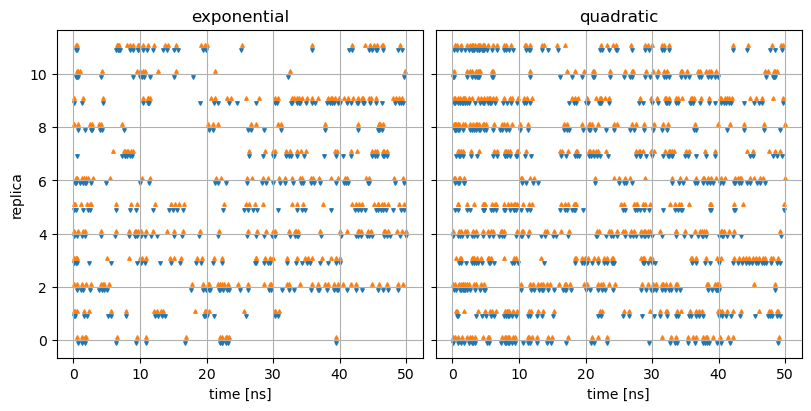

In [36]:
def roundtrip_plot(sim, ax=None, title=None):
    TIME_PER_FRAME = 50 / 250_000
    ax = ax or plt.gca()
    down_events = []
    down_events_state = []
    up_events = []
    up_events_state = []
    for i, col in enumerate(get_roundtrip_events(sim).T):
        n_down = (col == -1).sum()
        down_events.append(np.flatnonzero(col == -1) * TIME_PER_FRAME)
        down_events_state.append(np.array([i-0.1]*n_down))
        n_up = (col == 1).sum()
        up_events.append(np.flatnonzero(col == 1) * TIME_PER_FRAME)
        up_events_state.append(np.array([i+0.1]*n_up))
    ax.scatter(np.concatenate(down_events), np.concatenate(down_events_state), marker='v', s=6)
    ax.scatter(np.concatenate(up_events), np.concatenate(up_events_state), marker='^', s=6)
    if title is not None:
        ax.set_title(title)

sim = Simulation("poongavanam-g16", "openff", "hremd-exponential", "chcl3")

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True, layout='constrained')
sim_1 = sim.with_method("hremd-exponential")
sim_2 = sim.with_method("hremd-quadratic")
roundtrip_plot(sim_1, ax=axes[0], title="exponential")
roundtrip_plot(sim_2, ax=axes[1], title="quadratic")
axes[0].set_ylabel("replica")
for ax in axes:
    ax.set_xlabel("time [ns]")
    ax.grid()
plt.savefig("outputs/si-figure-chcl3-g16-roundtrip-events.png", dpi=300)
plt.show()

# SI Figure 2 G16 exchange rates

/tmp/ipykernel_2211651/4281662051.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(rates, "o", **kwargs)


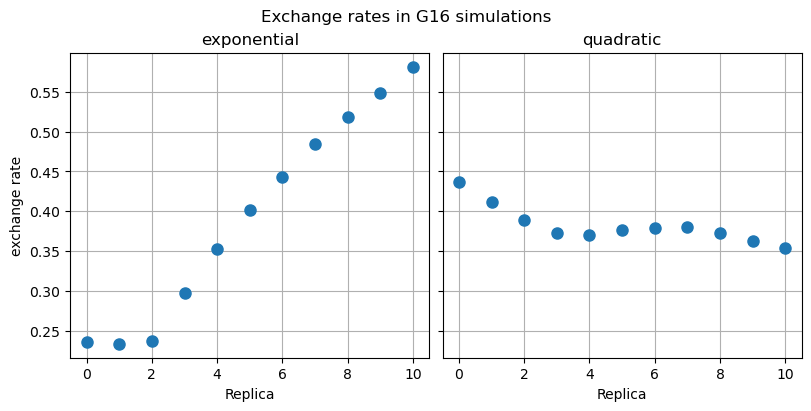

In [37]:
def get_exchange_rates(sim):
    with open(f"outputs/exchange-rates/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}.json") as f:
        return json.load(f)["success_rates"]

def exchange_rate_plot(sim, ax, **kwargs):
    rates = get_exchange_rates(sim)
    ax.plot(rates, "o", **kwargs)

fig, ax_row = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, layout='constrained')

simulations = [
    Simulation("poongavanam-g16", "openff", "hremd-exponential", "chcl3"),
]

pad = 5

for sim, symbol in zip(simulations, "ov^"):
    sim_1 = sim.with_method("hremd-exponential")
    sim_2 = sim.with_method("hremd-quadratic")
    exchange_rate_plot(sim_1, ax=ax_row[0], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)
    exchange_rate_plot(sim_2, ax=ax_row[1], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)

for ax in ax_row:
    ax.set_xlabel("Replica")
    ax.grid()
ax_row[0].set_title("exponential")
ax_row[1].set_title("quadratic")
ax_row[0].set_ylabel("exchange rate")
fig.suptitle("Exchange rates in G16 simulations")

plt.savefig("outputs/si-figure-chcl3-exchange-rate.png", dpi=300)
plt.show()

# SI Figure 3 Exchange rates

/tmp/ipykernel_2211651/2878200755.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(rates, "o", **kwargs)


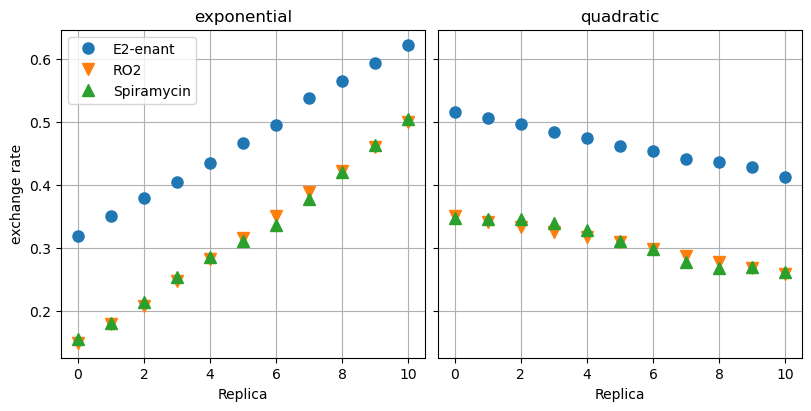

In [38]:
def get_exchange_rates(sim):
    with open(f"outputs/exchange-rates/{sim.compound}_{sim.solvent}_{sim.method}_{sim.forcefield}.json") as f:
        return json.load(f)["success_rates"]

def exchange_rate_plot(sim, ax, **kwargs):
    rates = get_exchange_rates(sim)
    ax.plot(rates, "o", **kwargs)

fig, ax_row = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True, layout='constrained')

simulations = [
    Simulation("poongavanam-e2-enant", "openff", "hremd-exponential", "water"),
    Simulation("roche-2", "openff", "hremd-exponential", "water"),
    Simulation("danelius-spiramycin", "openff", "hremd-exponential", "water"),
]

pad = 5

for sim, symbol in zip(simulations, "ov^"):
    sim_1 = sim.with_method("hremd-exponential")
    sim_2 = sim.with_method("hremd-quadratic")
    exchange_rate_plot(sim_1, ax=ax_row[0], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)
    exchange_rate_plot(sim_2, ax=ax_row[1], label=COMPOUNDS_PRETTY[sim.compound], marker=symbol, markersize=8)

for ax in ax_row:
    ax.set_xlabel("Replica")
    ax.grid()
ax_row[0].set_title("exponential")
ax_row[1].set_title("quadratic")
ax_row[0].set_ylabel("exchange rate")
ax_row[0].legend()

plt.savefig("outputs/si-figure-water-exchange-rate.png", dpi=300)
plt.show()

# SI Figure 4 Roundtrips

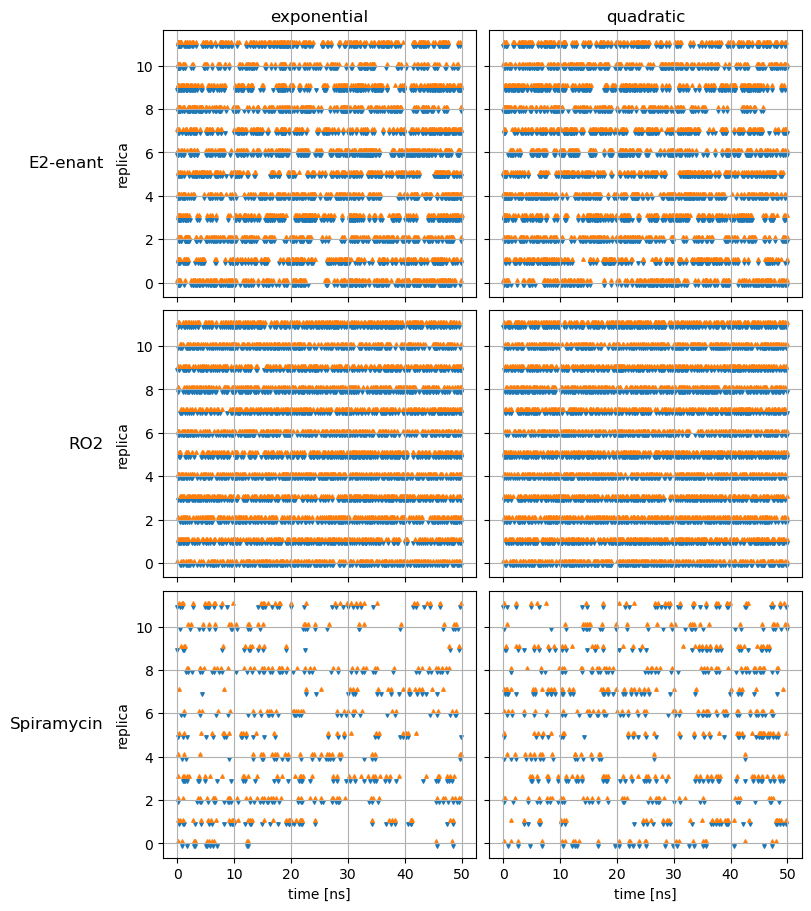

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(8, 9), sharex=True, sharey=True, layout='constrained')

simulations = [
    Simulation("poongavanam-e2-enant", "openff", "hremd-exponential", "water"),
    Simulation("roche-2", "openff", "hremd-exponential", "water"),
    Simulation("danelius-spiramycin", "openff", "hremd-exponential", "water"),
]

pad = 5

for i_row, (sim, ax_row) in enumerate(zip(simulations, axes)):
    sim_1 = sim.with_method("hremd-exponential")
    sim_2 = sim.with_method("hremd-quadratic")
    roundtrip_plot(sim_1, ax=ax_row[0])
    roundtrip_plot(sim_2, ax=ax_row[1])
    if i_row == 0:
        ax_row[0].set_title("exponential")
        ax_row[1].set_title("quadratic")
    ax_row[0].set_ylabel("replica")
    ax_row[0].annotate(
        COMPOUNDS_PRETTY[sim.compound],
        xy=(0, 0.5),
        xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax_row[0].yaxis.label,
        textcoords='offset points',
        ha='right',
        va='center',
        size='large',
    )
    for ax in ax_row:
        if i_row == len(simulations) - 1:
            ax.set_xlabel("time [ns]")
        ax.grid()

plt.savefig("outputs/si-figure-water-roundtrips.png", dpi=300)
plt.show()

# SI Figure 5 Lorlatinib

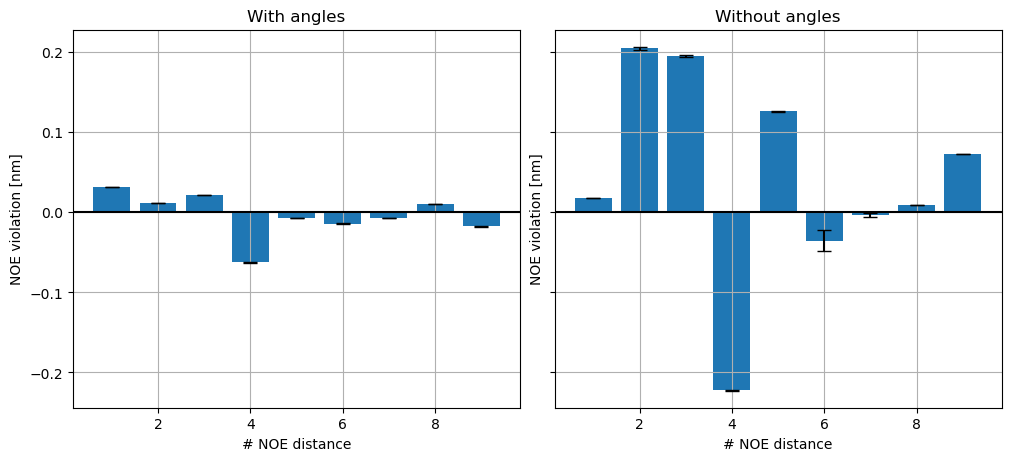

In [40]:
ANGSTROM_PER_NM = 10.

def violation_plot(simulation, ax=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.index, plot_df["violation"] / ANGSTROM_PER_NM, label='full')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df["violation"] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=5)
    ax.axhline(0, color='k')
    ax.set(xlabel='# NOE distance', ylabel='NOE violation [nm]')
    tick_spacing = max(2, int(np.ceil(len(plot_df) / 12)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharey=True, layout='constrained')
sims = {
    "With angles": Simulation("peng-lorlatinib", "openff", "hremd-with-angles", "chcl3"),
    "Without angles": Simulation("peng-lorlatinib", "openff", "hremd-quadratic", "chcl3"),
}

for ax, (title, sim) in zip(axes, sims.items()):
    violation_plot(sim, ax=ax)
    ax.set_title(title)
    ax.grid()
plt.savefig("outputs/si-figure-lorlatinib-with-without-angles.png", dpi=300)
plt.show()

# SI Figures with all bar plots
## SI Figure 7: Chloroform

In [41]:
FORCEFIELDS_PRETTY_CONFS = {'openff': 'OpenFF 2',
 'openff-confs': 'OpenFF 2 (10 conformers)',
 'amber': 'GAFF2',
 'opls': 'OPLS/AA',
 'xff-dash': 'XFF/DASH'}

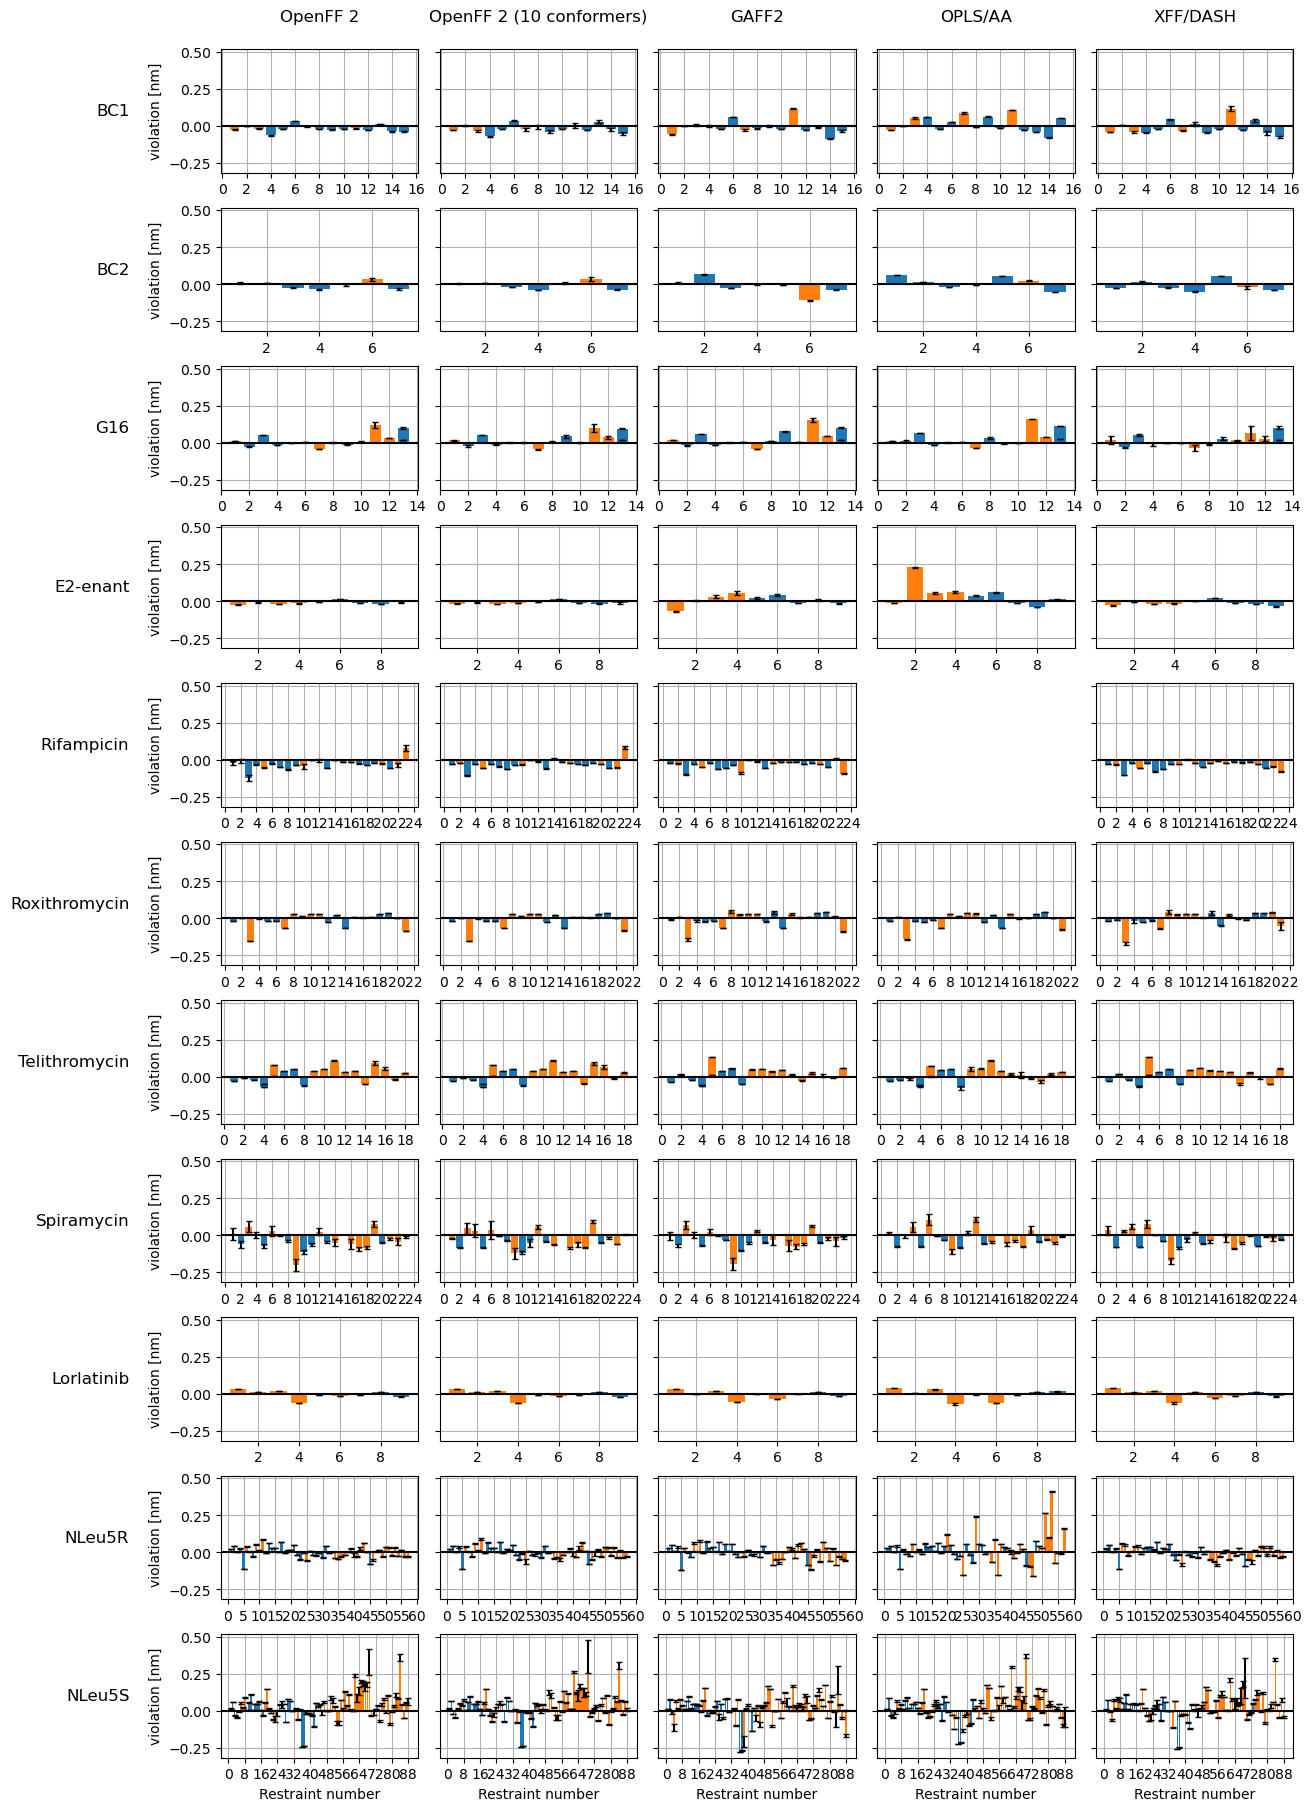

In [42]:
ANGSTROM_PER_NM = 10.

def make_plot(simulation, frame_selection=None, ax=None, use_ring_distance=False, restraints_df=None):
    ax = ax or plt.gca()
    plot_df = get_results_table(simulation)
    # Plot
    ax.bar(plot_df.query('top_distance <= 4.0').index, plot_df.query('top_distance <= 4.0')['violation'] / ANGSTROM_PER_NM, label='≤ 4 bonds')
    ax.bar(plot_df.query('top_distance > 4.0').index, plot_df.query('top_distance > 4.0')['violation'] / ANGSTROM_PER_NM, label='> 4 bonds')
    N_CHUNKS = 5
    std = np.array([
        (plot_df[f'distance_split_{i}'] - plot_df['distance_ab']).values
        for i in range(N_CHUNKS)
    ]).std(0)
    ax.errorbar(plot_df.index, plot_df['violation'] / ANGSTROM_PER_NM, std / ANGSTROM_PER_NM, fmt='k.', markersize=0, capsize=2)
    #ax.legend()
    ax.axhline(0, color='k')
    # limit the number of x-ticks. Note: there will often be one more, since matplotlib extends the plot a bit.
    max_number_of_ticks = 12
    tick_spacing = max(2, int(np.ceil(len(plot_df) / max_number_of_ticks)))
    ax.xaxis.set_major_locator(plt.MultipleLocator(tick_spacing))

fig, axes = plt.subplots(11, 5, figsize=(13, 18), sharey=True, layout='constrained')
CHCL3_COMPOUNDS_PRETTY = {
    k: v
    for k, v in COMPOUNDS_PRETTY.items()
    if not "charged" in k and not "zwitterion" in k and not k.startswith("roche")
}

for axline, (cmp, compound_pretty) in zip(axes, CHCL3_COMPOUNDS_PRETTY.items()):
    for ax, (ff, ff_pretty) in zip(axline, FORCEFIELDS_PRETTY_CONFS.items()):
        sim = Simulation(cmp, ff, standard_md_method(cmp), "chcl3")
        if (cmp, ff) == ("danelius-rifampicin", "opls"):
            ax.set_visible(False)
            continue
        make_plot(sim, ax=ax)
        if axline[0] is axes[0, 0]:  # first row
            ax.set_title(ff_pretty, pad=20)
        ax.grid()
        # The plot (bars, error bars) should be above the grid lines
        ax.set_axisbelow(True)
    _pad = 10
    axline[0].annotate(
        compound_pretty, xy=(0., 0.5), xytext=(-axline[0].yaxis.labelpad - _pad, 0),
        xycoords=axline[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center',
    )
    axline[0].set_ylabel("violation [nm]")

for ax in axes[-1]: # last row
    ax.set_xlabel("Restraint number")
# for SI figures I think it's ok to use SVG.
plt.savefig("outputs/si-figure-6-all-bar-plots-chloroform.svg")
plt.show()

## SI Figure 8: Water

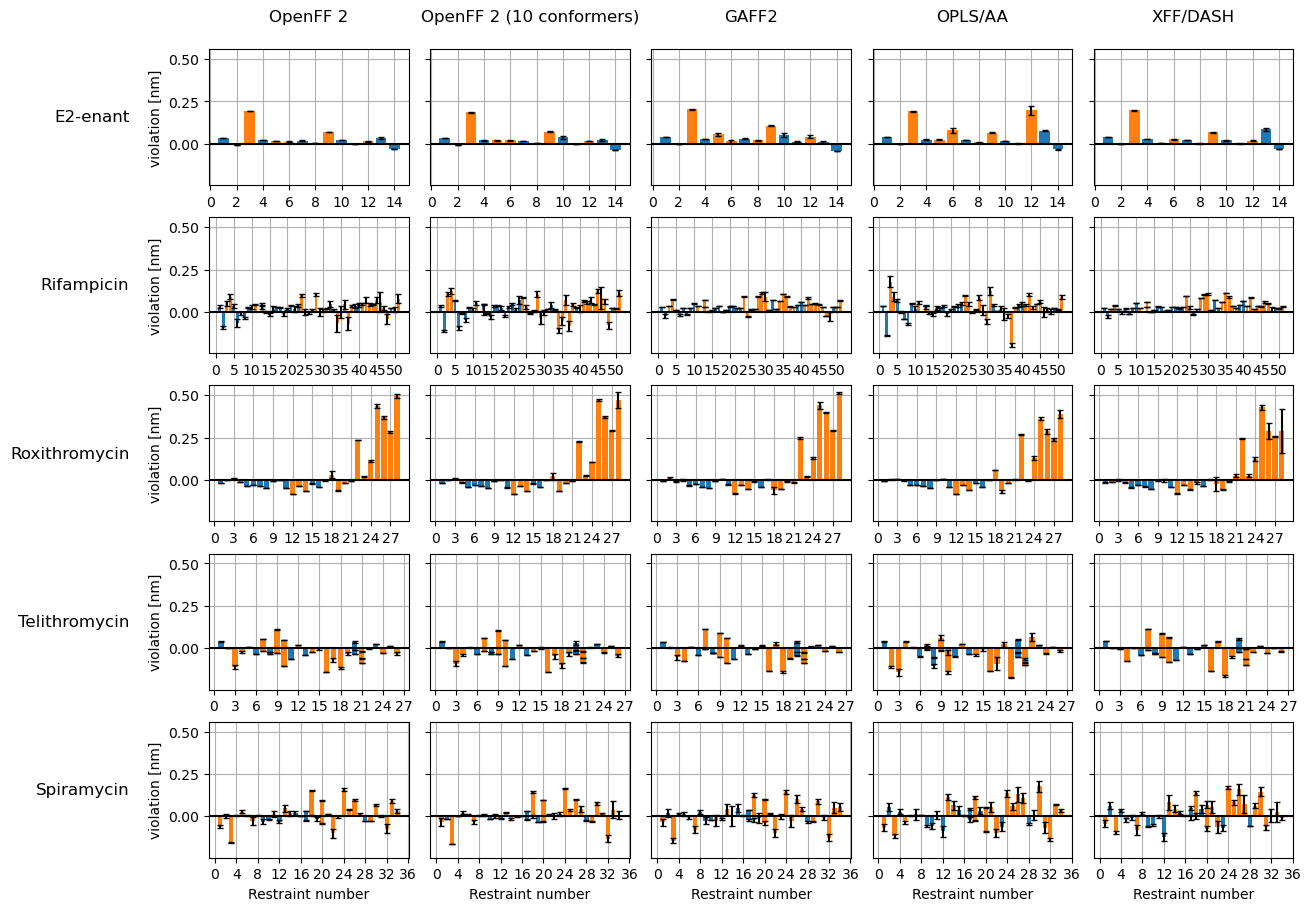

In [43]:
WAT_COMPOUNDS_PRETTY = {k: v for k, v in COMPOUNDS_PRETTY.items() if k in ("danelius-roxithromycin-charged", "danelius-telithromycin-charged", "danelius-rifampicin-charged", "danelius-spiramycin-charged", "poongavanam-e2-enant")}
fig, axes = plt.subplots(len(WAT_COMPOUNDS_PRETTY), 5, figsize=(13, 9), sharey=True, layout='constrained')

for axline, (cmp, compound_pretty) in zip(axes, WAT_COMPOUNDS_PRETTY.items()):
    for ax, (ff, ff_pretty) in zip(axline, FORCEFIELDS_PRETTY_CONFS.items()):
        sim = Simulation(cmp, ff, standard_md_method(cmp), "water")
        make_plot(sim, ax=ax)
        if axline[0] is axes[0, 0]:  # first row
            ax.set_title(ff_pretty, pad=20)
        ax.grid()
        ax.set_axisbelow(True)
    _pad = 10
    axline[0].annotate(
        compound_pretty, xy=(0., 0.5), xytext=(-axline[0].yaxis.labelpad - _pad, 0),
        xycoords=axline[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center',
    )
    axline[0].set_ylabel("violation [nm]")

for ax in axes[-1]: # last row
    ax.set_xlabel("Restraint number")
# for SI figures I think it's ok to use SVG.
plt.savefig("outputs/si-figure-7-all-bar-plots-water.svg")
plt.show()

## SI Figure 9: DMSO

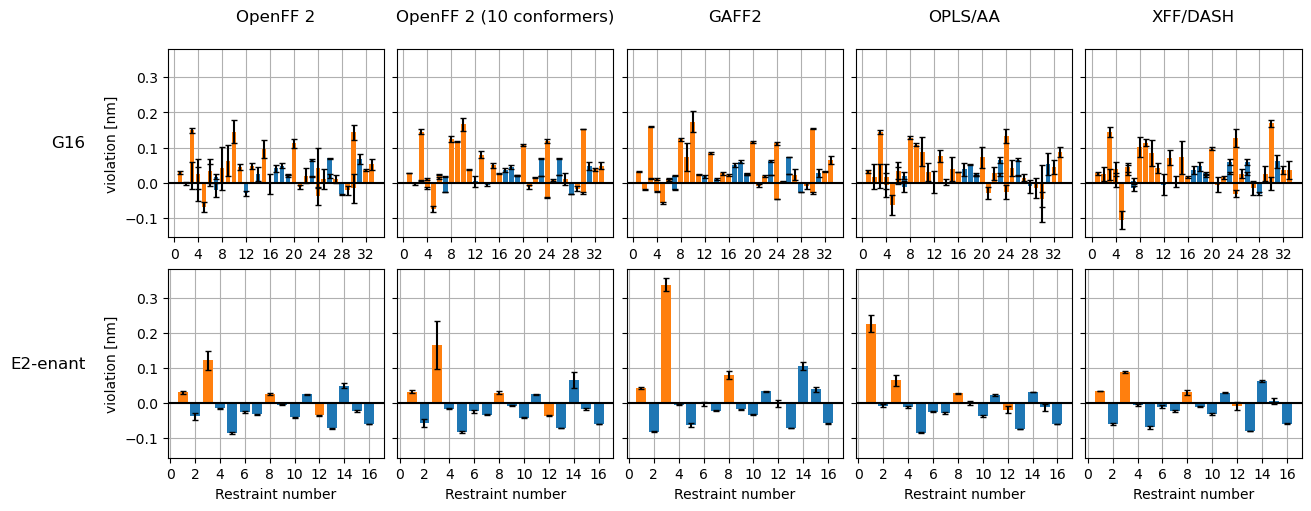

In [44]:
DMSO_COMPOUNDS_PRETTY = {k: v for k, v in COMPOUNDS_PRETTY.items() if k in ("poongavanam-e2-enant", "poongavanam-g16")}
fig, axes = plt.subplots(len(DMSO_COMPOUNDS_PRETTY), 5, figsize=(13, 5), sharey=True, layout='constrained')

for axline, (cmp, compound_pretty) in zip(axes, DMSO_COMPOUNDS_PRETTY.items()):
    for ax, (ff, ff_pretty) in zip(axline, FORCEFIELDS_PRETTY_CONFS.items()):
        sim = Simulation(cmp, ff, standard_md_method(cmp), "dmso")
        make_plot(sim, ax=ax)
        if axline[0] is axes[0, 0]:  # first row
            ax.set_title(ff_pretty, pad=20)
        ax.grid()
        ax.set_axisbelow(True)
    _pad = 10
    axline[0].annotate(
        compound_pretty, xy=(0., 0.5), xytext=(-axline[0].yaxis.labelpad - _pad, 0),
        xycoords=axline[0].yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center',
    )
    axline[0].set_ylabel("violation [nm]")

for ax in axes[-1]: # last row
    ax.set_xlabel("Restraint number")
# for SI figures I think it's ok to use SVG.
plt.savefig("outputs/si-figure-8-all-bar-plots-dmso.svg")
plt.show()

## SI Figure 10: Restraint violations with ring classification

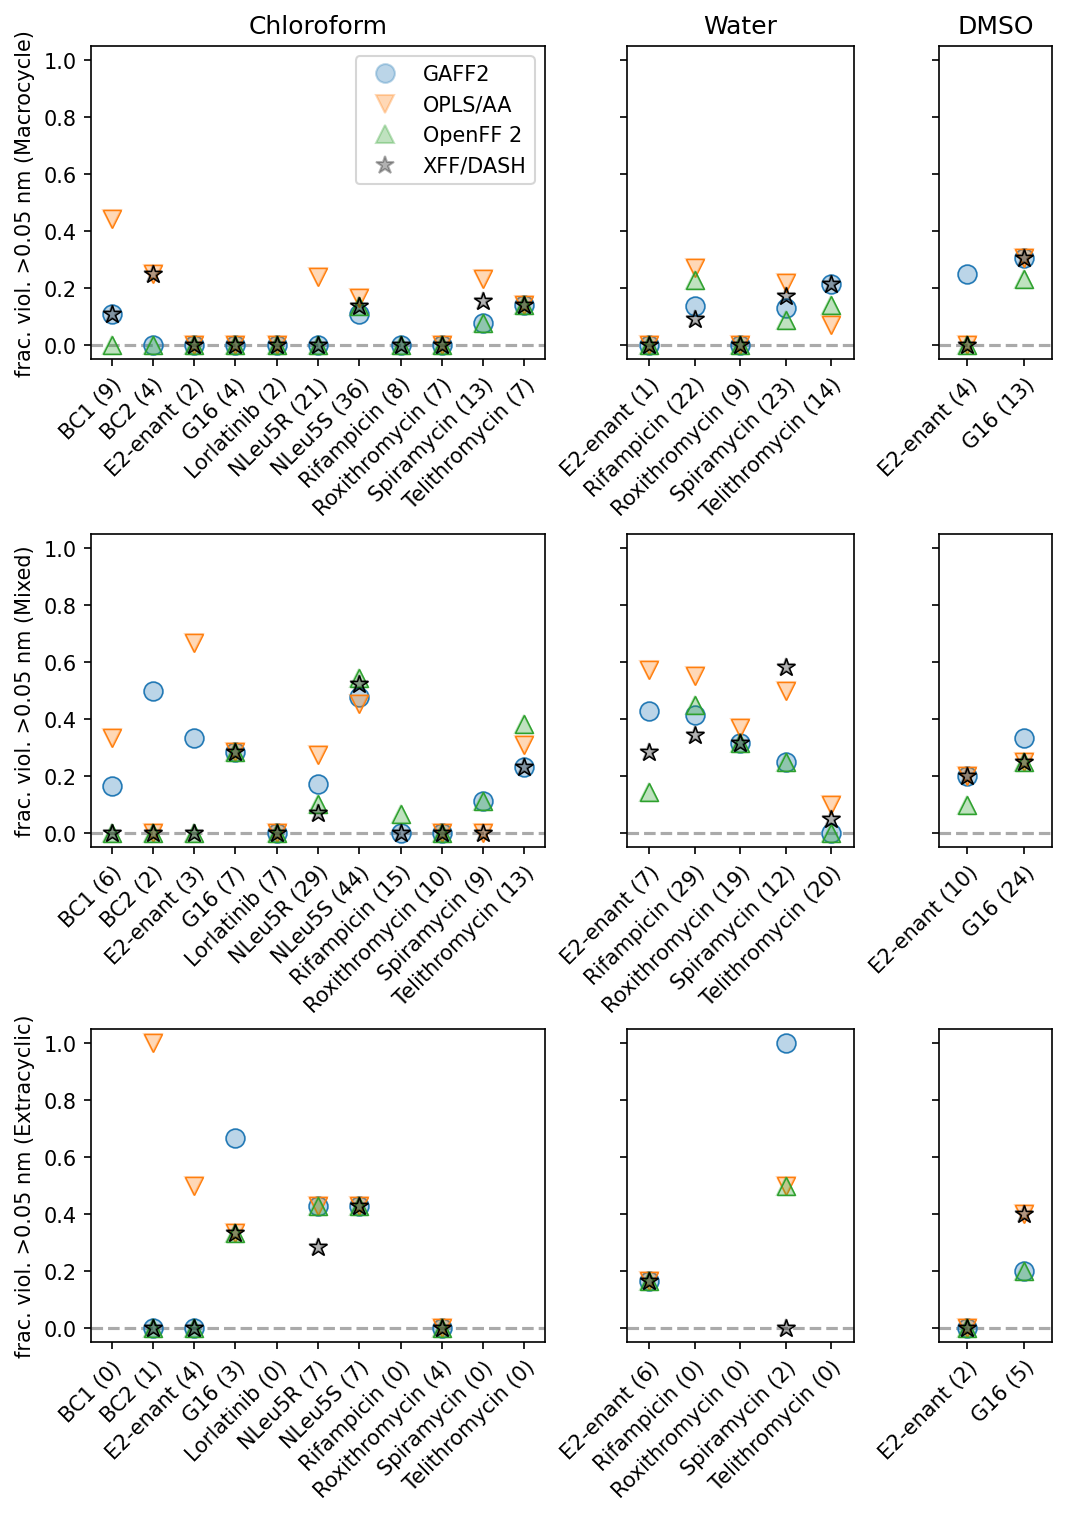

In [45]:
# Setup
fig, axes_2d = plt.subplots(3, 3, figsize=(7, 10), dpi=150, layout='constrained', sharey=True, sharex=False, gridspec_kw={'width_ratios': [4, 2, 1]})
aggregation = lambda x: fraction_above(x, cutoff=.5)
colors = [row['color'] for row in plt.rcParams['axes.prop_cycle']][:4]
colors[3] = '#000'
forcefields = ['openff', 'amber', 'opls', 'xff-dash']

SOLVENT_COMPOUNDS = [
    ("chcl3", "Chloroform", [
        'begnini-compound-1', 'begnini-compound-2',
        'poongavanam-g16', 'poongavanam-e2-enant',
        'danelius-rifampicin', 'danelius-roxithromycin', 'danelius-telithromycin', 'danelius-spiramycin',
        'peng-lorlatinib',
        'comeau-nleu5r', 'comeau-nleu5s',
    ]),
    ("water", "Water", [
        'poongavanam-e2-enant',
        'danelius-rifampicin-zwitterion', 'danelius-roxithromycin-charged', 'danelius-telithromycin-charged', 'danelius-spiramycin-charged',
    ]),
    ("dmso", "DMSO", ['poongavanam-e2-enant', 'poongavanam-g16']),
]

for axes, subset in zip(axes_2d, ["macrocycle", "mixed", "extracyclic"]):
    
    for ax, (solvent, solvent_pretty, compounds) in zip(axes, SOLVENT_COMPOUNDS):
        ax.axhline(0, color='#aaa', linestyle='--')

        aggregation = lambda x: fraction_above(x, cutoff=.5)
        plot_df = pd.Series({
            (COMPOUNDS_PRETTY[compound], FORCEFIELDS_PRETTY[ff]): get_results_table(
                Simulation(compound, ff, standard_md_method(compound), solvent),
            ).query(f"ring_classification == \"{subset}\"")['violation']
            for compound in compounds
            for ff in forcefields
            if (compound, ff) != ('danelius-rifampicin', 'opls')
        })
        #dummy = pd.DataFrame(index=[COMPOUNDS_PRETTY[c] for c in compounds])
        plot_df_agg = plot_df.map(aggregation).unstack(level=1)
        plot_df_n_points = plot_df.map(len).unstack(level=1)["OpenFF 2"].astype(int)
        # # sort by the lowest value
        # for n in range(3, -1, -1):
        #     plot_df_agg = sort_by_nth_lowest(plot_df_agg, n)
        for col, marker, color in zip (plot_df_agg, "ov^*", colors):
            ax.plot(plot_df_agg.index, plot_df_agg[col], label=col, markersize=9, marker=marker, linestyle='none', color=color, alpha=0.3)
            ax.plot(plot_df_agg.index, plot_df_agg[col], markersize=9, marker=marker, linestyle='none', color=color, markeredgewidth=0.7, markerfacecolor='None')
        plt.xticks(rotation=45, ha='right', rotation_mode="anchor")
        ax.set_xticks(
            np.arange(len(plot_df_agg.index)),
            [f"{name} ({n})" for name, n in zip(plot_df_agg.index, plot_df_n_points.values)]
        )
        ax.set_xlim(-0.5, len(plot_df_agg.index) - 0.5)
        #ax.tick_params("x", labelbottom=True)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor",)
        if solvent == "chcl3":  # only in the first column
            ax.set(ylabel=f"frac. viol. >0.05 nm ({subset.title()})")
        if subset == "macrocycle":  # only in the first row
            ax.set_title(solvent_pretty)
axes_2d[0][0].legend()
plt.savefig("outputs/si-figure-frac-violations-over-0.5-ring-classification.png", dpi=300)
plt.show()

# Table 3: Standard deviations

In [46]:
PUBLIC_COMPOUNDS = {
    "chcl3": [
        "begnini-compound-1", "begnini-compound-2", "poongavanam-g16", "poongavanam-e2-enant", "danelius-rifampicin",
        "danelius-roxithromycin", "danelius-telithromycin", "danelius-spiramycin", "peng-lorlatinib", "comeau-nleu5r", "comeau-nleu5s"
    ],
    "water": ["poongavanam-e2-enant", "danelius-rifampicin-zwitterion", "danelius-roxithromycin-charged", "danelius-telithromycin-charged", "danelius-spiramycin-charged"],
    "dmso": ["poongavanam-g16", "poongavanam-e2-enant"],
}

In [47]:
split_cols = [f'distance_split_{i}' for i in range(5)]
def get_std_per_distance(solvent):
    out = pd.Series()
    for compound in PUBLIC_COMPOUNDS[solvent]:
        sim = Simulation(compound, 'openff', standard_md_method(compound), solvent)
        split_std = get_results_table(sim)[split_cols].std(1)
        out[COMPOUNDS_PRETTY[compound]] = root_mean_square(split_std)
    return out
print(
    pd.DataFrame({
        "Chloroform": get_std_per_distance("chcl3"),
        "Water": get_std_per_distance("water"),
        "DMSO": get_std_per_distance("dmso"),
    }).divide(10).rename_axis("Compound")
    #.to_latex(na_rep=" "*5, float_format="%.4f")
    .to_string(float_format="%.4f")
)

               Chloroform  Water   DMSO
Compound                               
BC1                0.0024    NaN    NaN
BC2                0.0061    NaN    NaN
E2-enant           0.0026 0.0026 0.0087
G16                0.0066    NaN 0.0276
Lorlatinib         0.0004    NaN    NaN
NLeu5R             0.0033    NaN    NaN
NLeu5S             0.0149    NaN    NaN
Rifampicin         0.0097 0.0165    NaN
Roxithromycin      0.0003 0.0063    NaN
Spiramycin         0.0247 0.0124    NaN
Telithromycin      0.0046 0.0048    NaN


# Dummy table for TOC graphic

In [48]:
from IPython.display import HTML
df = pd.DataFrame({"Atom 1": ["H1", "H24"], "Atom 2": ["H1", "H2"], "Distance": [5.5, 3.6]})
HTML(df.to_html(index=False))

# SI Figure 6: 2D-RMSD

In [49]:
from functools import lru_cache

In [50]:
@lru_cache(32)
def rms_2d(sim: Simulation, stride=50):
    traj = trajectory(sim)[:50_001:stride]
    center_traj(traj)
    rms_2d = []
    for i_frame in range(traj.n_frames):
        rms_2d.append(md.rmsd(traj, traj, frame=i_frame))
    return np.array(rms_2d)

In [51]:
COMPOUNDS = [
    'begnini-compound-1',
    'begnini-compound-2',
    'poongavanam-g16',
    'poongavanam-e2-enant',
    'danelius-rifampicin',
    'danelius-roxithromycin',
    'danelius-telithromycin',
    'danelius-spiramycin',
    'peng-lorlatinib',
    'comeau-nleu5r',
    'comeau-nleu5s',
]

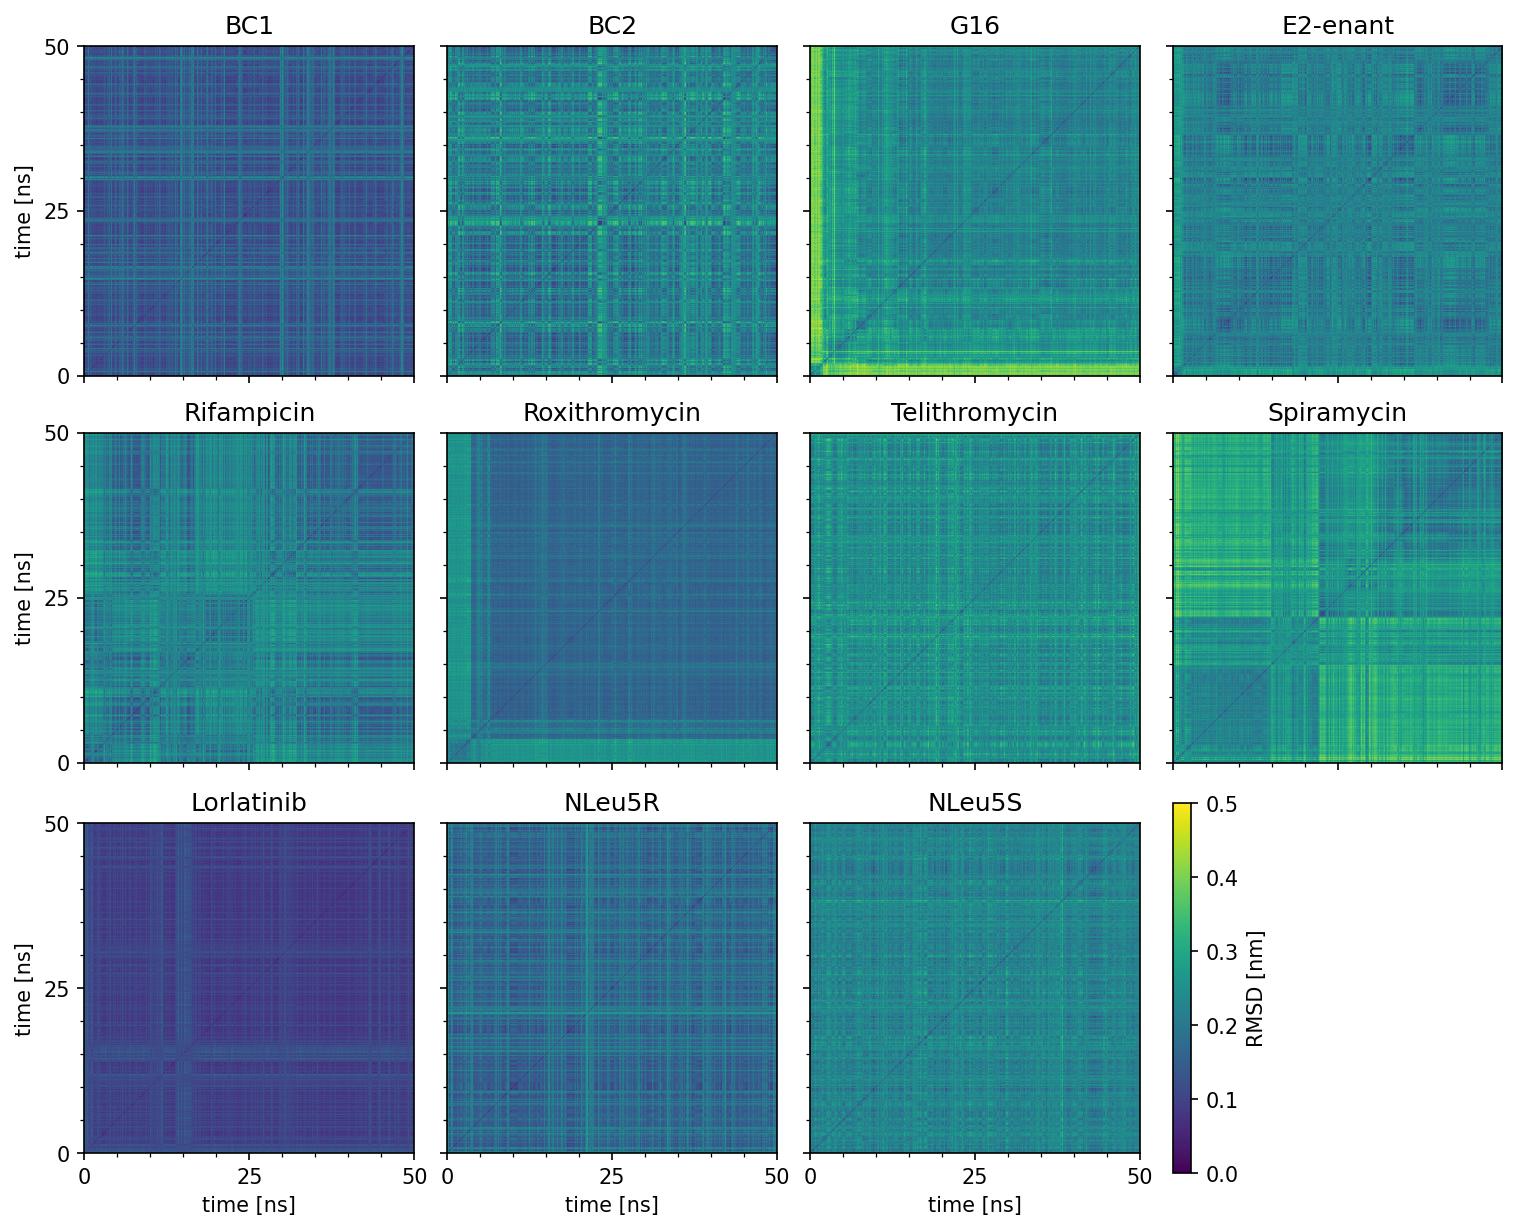

In [53]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8), dpi=150, layout="constrained", sharex=True, sharey=True)
for compound, ax in zip(COMPOUNDS, axes.ravel()):
    sim = Simulation(compound, "openff", "hremd-quadratic", "chcl3")
    im = ax.imshow(rms_2d(sim), origin="lower", extent=(0, 50, 0, 50), vmin=0, vmax=0.5)
    ax.set(title=COMPOUNDS_PRETTY[compound])
    ax.xaxis.set_major_locator(plt.MultipleLocator(25))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
    ax.yaxis.set_major_locator(plt.MultipleLocator(25))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
#for ax in axes[:, -1]:
cbar = fig.colorbar(im, ax=axes[-1, -1], pad=-1)
cbar.set_label("RMSD [nm]")
for ax in axes[-1]:
    ax.set(xlabel="time [ns]")
for ax in axes[:, 0]:
    ax.set(ylabel="time [ns]")

axes[-1][-1].set_visible(False)
# Incorrect numbering: should be SI Fig 6
plt.savefig("outputs/si-figure-9-rmsd.png")
plt.show()

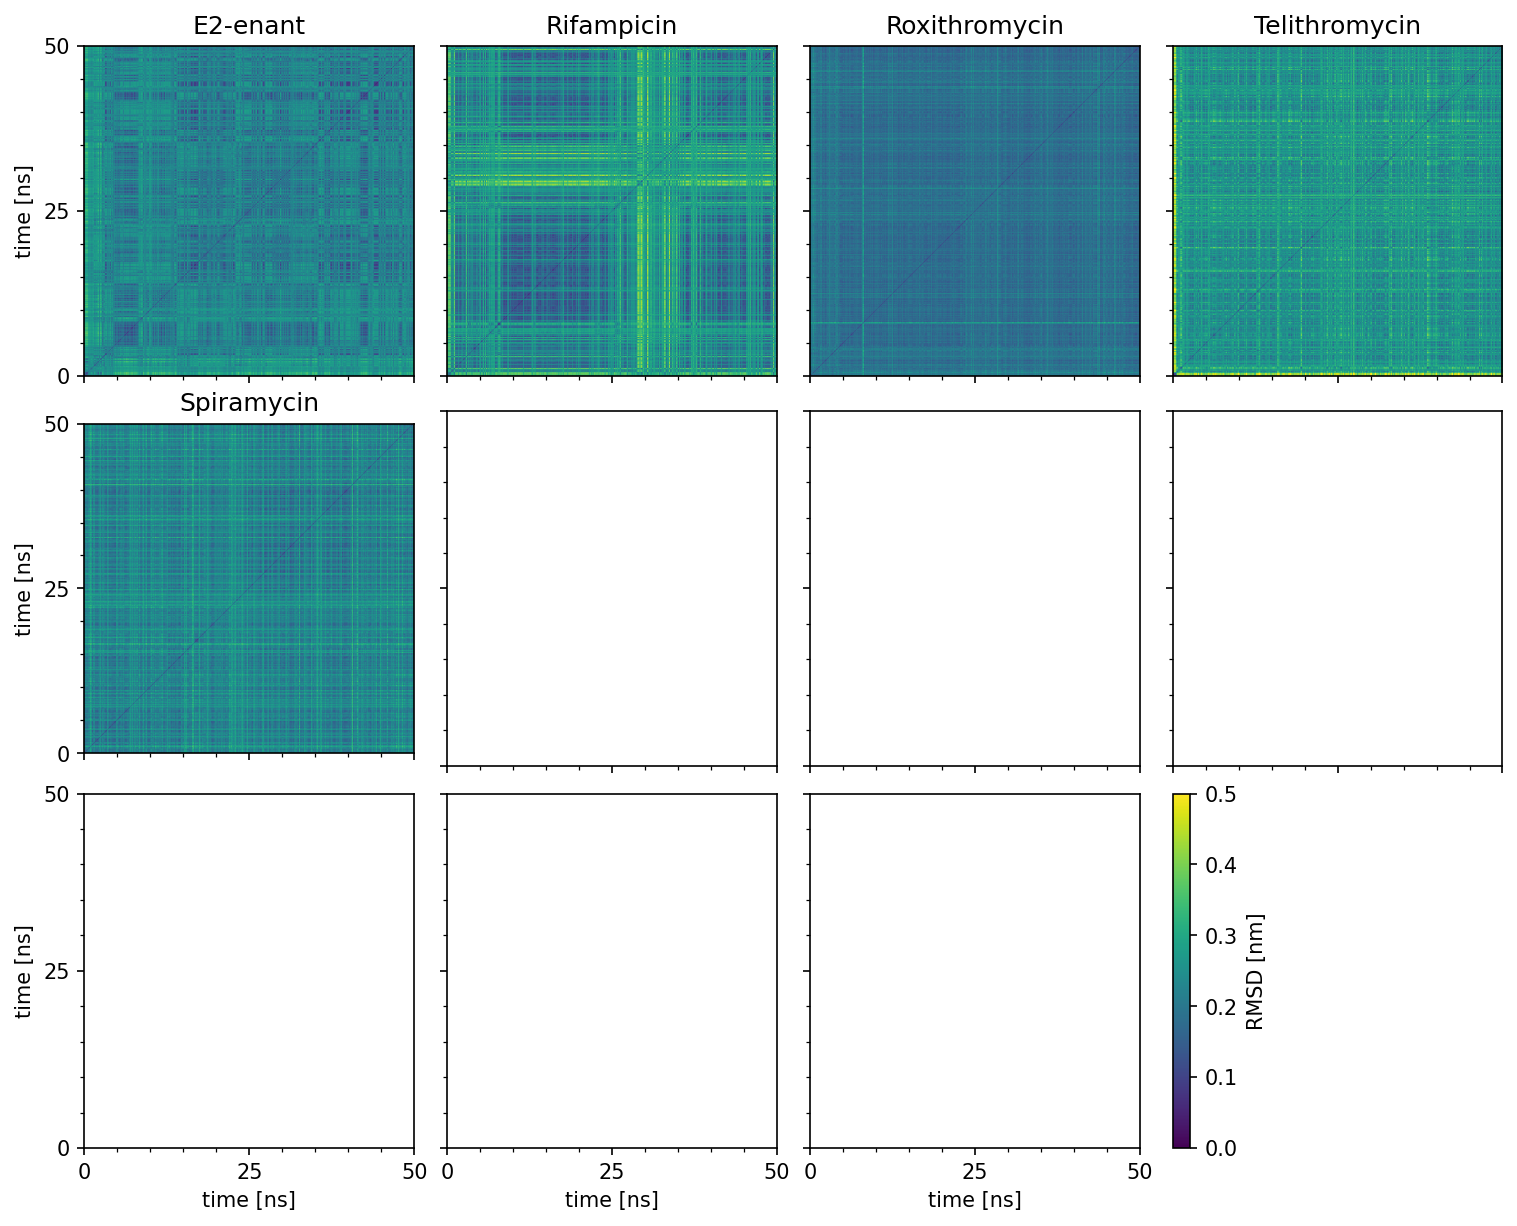

In [54]:
COMPOUNDS = [
    'poongavanam-e2-enant',
    'danelius-rifampicin-zwitterion',
    'danelius-roxithromycin-charged',
    'danelius-telithromycin-charged',
    'danelius-spiramycin-charged',
]
fig, axes = plt.subplots(3, 4, figsize=(10, 8), dpi=150, layout="constrained", sharex=True, sharey=True)
for compound, ax in zip(COMPOUNDS, axes.ravel()):
    sim = Simulation(compound, "openff", "hremd-quadratic", "water")
    try:
        im = ax.imshow(rms_2d(sim), origin="lower", extent=(0, 50, 0, 50), vmin=0, vmax=0.5)
        ax.set(title=COMPOUNDS_PRETTY[compound])
        ax.xaxis.set_major_locator(plt.MultipleLocator(25))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(5))
        ax.yaxis.set_major_locator(plt.MultipleLocator(25))
        ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
    except Exception as e:
        print(e)
        continue
#for ax in axes[:, -1]:
cbar = fig.colorbar(im, ax=axes[-1, -1], pad=-1)
cbar.set_label("RMSD [nm]")
for ax in axes[-1]:
    ax.set(xlabel="time [ns]")
for ax in axes[:, 0]:
    ax.set(ylabel="time [ns]")

axes[-1][-1].set_visible(False)
plt.savefig("outputs/si-figure-9-rmsd-water.png")
plt.show()

# Figure 7A: plot partial charges

In [55]:
def get_partial_charges(compound):
    return pd.read_csv(f"../data/10-conformers-partial-charges/{compound}-charges.csv", index_col="i_conformer")
get_partial_charges("begnini-compound-1")

i_atom    charge
i_conformer                  
0                 0  0.119683
0                 1 -0.429917
0                 2  0.602083
0                 3 -0.540017
0                 4  0.073683
...             ...       ...
9                55  0.045717
9                56  0.067050
9                57  0.067050
9                58  0.067050
9                59  0.328517

[600 rows x 2 columns]

In [56]:
COMPOUNDS = [c for c in COMPOUNDS_PRETTY if not "charged" in c and "zwitterion" not in c and not "roche" in c]

begnini-compound-1 29 0.07698326666666677
begnini-compound-2 15 0.05203330000000006
poongavanam-g16 44 0.0740322688172043
poongavanam-e2-enant 15 0.0659710724637681
danelius-rifampicin 49 0.1830084786324786
danelius-roxithromycin 91 0.0839999552238806
danelius-telithromycin 60 0.0780000487804879
danelius-spiramycin 21 0.0779624436090226
peng-lorlatinib 25 0.07997961224489791
comeau-nleu5r 9 0.06504408823529417
comeau-nleu5s 9 0.07991180882352933


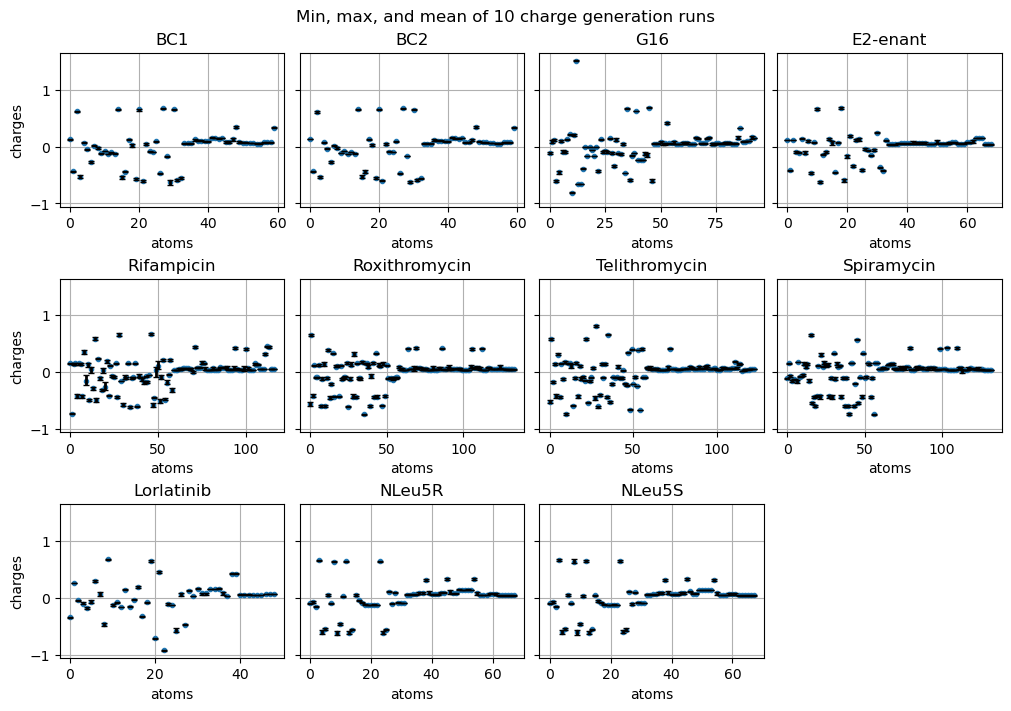

In [57]:
fig, axes = plt.subplots(3, 4, figsize=(10, 7), layout="constrained", sharey=True)
for compound, ax in zip(COMPOUNDS, axes.ravel()):
    try:
        charges = get_partial_charges(compound)
    except FileNotFoundError:
        print(f"Skipping {compound}")
        continue
    charge_min = charges.groupby("i_atom").min().values.ravel()
    charge_max = charges.groupby("i_atom").max().values.ravel()
    charge_mean = charges.groupby("i_atom").mean().values.ravel()
    
    charge_diff = charge_max - charge_min
    print(compound, charge_diff.argmax(), charge_diff.max())

    ax.plot(np.arange(len(charge_mean)), charge_mean, ".", markersize=6)
    ax.errorbar(np.arange(len(charge_mean)), np.mean([charge_min, charge_max], axis=0), (charge_max - charge_min) / 2, linestyle="", capsize=2, color='k', elinewidth=2)
    ax.set_title(COMPOUNDS_PRETTY[compound])
    ax.set_xlabel("atoms")
    ax.grid()
for ax in axes[:, 0]:
    ax.set_ylabel("charges")
axes[-1, -1].set_visible(0)
fig.suptitle("Min, max, and mean of 10 charge generation runs")
fname = "outputs/figure-range-of-partial-charges.png"
plt.savefig(fname, dpi=300)
plt.show()